# Анализ бизнес-показателей в Яндекс.Афиша


**Автор:**  

Григорьев Павел


**Описание проекта:**   

Маркетологи Яндекс.Афиши нацелены на оптимизацию расходов и повышение эффективности рекламных кампаний. Для достижения этой цели необходимо провести глубокий анализ логов сервера, выгрузок заказов и статистики рекламных расходов. Это позволит выявить неэффективные источники трафика и оптимально перераспределить бюджет. Ключевые задачи проекта включают изучение поведения клиентов на сайте, определение времени первых покупок, расчет доходности каждого клиента и анализ сроков окупаемости затрат на привлечение. Полученные результаты помогут не только снизить затраты, но и значительно улучшить маркетинговые стратегии, обеспечивая более высокий возврат на инвестиции. ⬤

**Цель:**  

Оптимизировать маркетинговые расходы и повысить эффективность рекламных стратегий путем анализа источников трафика и поведения клиентов, с целью выявления неэффективных каналов.

**Источники данных:**  

- лог сервера с данными о посещениях сайта Яндекс.Афиши
- выгрузка всех заказов
- статистика рекламных расходов

**Условия проведения анализа данных:**  

Для анализ будут использоваться данные с июня 2017 по конец мая 2018 года.

## Загрузка библиотек <skip>

In [90]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import pagri_data_tools  # type: ignore
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Описание и изучение данных


### Описание данных


**Таблица visits_log (лог сервера с информацией о посещениях сайта):**

- Uid - уникальный идентификатор пользователя,
- Device - категория устройства пользователя,
- Start Ts - дата и время начала сессии,
- End Ts - дата и время окончания сессии,
- Source Id - идентификатор источника перехода на сайт.


**Таблица orders_log (информацию о заказах):**

- Uid - уникальный идентификатор пользователя,
- Buy Ts - дата и время заказа,
- Revenue - сумма заказа.

**Таблица costs (информацию о расходах на маркетинг):**

- source_id - идентификатор рекламного источника,
- dt - дата проведения рекламной кампании,
- costs - расходы на эту кампанию.

### Изучение данных


#### Изучение переменных


##### Таблица visits_log (лог сервера с информацией о посещениях сайта)

Загружаем данные и задаем типы данных для столбцов, где это возможно.

In [91]:
dtype = {'Device': 'category', 'Source Id': 'category'}
df_visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv', dtype=dtype
                , parse_dates=['End Ts', 'Start Ts'], date_format='%Y-%m-%d %H:%M:%S')
df_visits.rename(columns={'Device': 'device', 'End Ts': 'session_end_dt', 'Start Ts': 'session_start_dt'
                          , 'Source Id': 'source_id', 'Uid': 'uid'}, inplace=True)
df_visits.sample(5, random_state=7)

,device,session_end_dt,source_id,session_start_dt,uid
349164,desktop,2018-04-24 09:37:00,2,2018-04-24 09:10:00,2569181675832811876
36050,desktop,2017-11-20 20:12:00,3,2017-11-20 19:15:00,8877700266692256763
189380,touch,2017-11-12 14:36:00,2,2017-11-12 14:13:00,7420756121024737125
351149,desktop,2017-12-07 16:09:00,4,2017-12-07 16:06:00,9717719112529363193
85669,desktop,2017-10-05 17:40:00,3,2017-10-05 17:39:00,8687122272170077156


In [92]:
gen = pagri_data_tools.info_gen(df_visits)
gen.next() 

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
359 400,5,9,---,---


In [93]:
gen.next()

First date,2017-06-01 00:02:00,,Zeros,---,,Years missing,0%,
Last date,2018-06-01 01:26:00,,Missing,---,,Months missing,0%,
Values,359 400 (100%),,Distinct,224 760 (63%),,Weeks missing,0%,
RAM (Mb),3,,Duplicates,134 640 (37%),,Days missing,<1%,


**Наблюдения:**  

- В дате окончания сессии последняя дата попала на следующий месяц, нужно это учесть при расчете метрик.
- В дате окончания сессии есть пропуски в днях, но совсем мало (меньше 1%)

In [94]:
gen.next()

First date,2017-06-01 00:01:00,,Zeros,---,,Years missing,0%,
Last date,2018-05-31 23:59:00,,Missing,---,,Months missing,0%,
Values,359 400 (100%),,Distinct,224 303 (62%),,Weeks missing,0%,
RAM (Mb),3,,Duplicates,135 097 (38%),,Days missing,<1%,


**Наблюдения:**  

- В дате начала сессии есть пропуски в днях, но совсем мало (меньше 1%)

In [95]:
gen.next(only_summary=True)

Values,359 400 (100%),
Missing,---,
Distinct,228 169 (63%),
Duplicates,131 231 (37%),
Zeros,---,
Negative,---,
RAM (Mb),3,


**Наблюдения:**  

- В таблице с логами о посещении сайта 63% уникльных пользователей.

Values,359 400 (100%),,desktop (73%)
Missing,---,,touch (27%)
Distinct,2 (<1%),,
Duplicated origin,359 398 (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

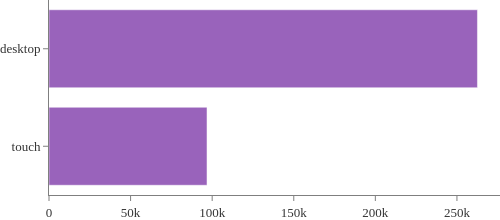

In [96]:
gen.next()

**Наблюдения:**  

- Пользователей с девайсами desktop 73%, пользователей с девайсами touchpad 27%

Values,359 400 (100%),,4 (28%)
Missing,---,,3 (24%)
Distinct,9 (<1%),,5 (19%)
Duplicated origin,359 391 (99.9%),,2 (13%)
Dupl (modify - origin),---,,1 (9%)
Empty,---,,9 (4%)
RAM (Mb),<1 Mb,,10 (3%)

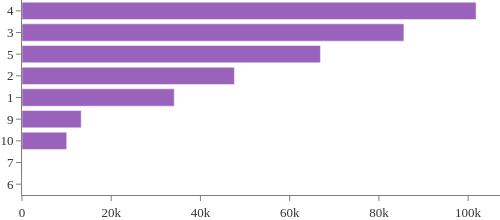

In [97]:
gen.next()

In [98]:
pagri_data_tools.value_counts_table(df_visits, 'source_id', chunk_size = 5, tables_in_row = 10)

4,101 794 (28.32%),|,9,13 277 (3.69%)
3,85 610 (23.82%),|,10,10 025 (2.79%)
5,66 905 (18.62%),|,7,36 (0.01%)
2,47 626 (13.25%),|,6,6 (0.0%)
1,34 121 (9.49%),|,,


**Наблюдения:**  

- В таблице визитов 9 униклальных источников перехода на сайт
- Источники 6 и 7 очень редко встречаются

#####  Таблица orders_log (информацию о заказах)

Загружаем данные и задаем типы данных для столбцов, где это возможно.

In [99]:
df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv'
                , parse_dates=['Buy Ts'], date_format='%Y-%m-%d %H:%M:%S')
df_orders.rename(columns={'Buy Ts': 'order_dt', 'Revenue': 'revenue', 'Uid': 'uid'}, inplace=True)
df_orders.sample(5, random_state=7)

,order_dt,revenue,uid
49089,2018-05-26 18:28:00,5.50,1811520111156483535
50332,2018-05-31 19:43:00,1.77,4194075740388201505
3675,2017-07-17 14:24:00,1.83,6363711940649679047
37863,2018-03-02 20:13:00,18.33,16208519295351883434
20859,2017-11-29 09:42:00,0.24,17752546109465586272


In [100]:
gen = pagri_data_tools.info_gen(df_orders)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
50 415,3,1,---,---


In [101]:
gen.next()

First date,2017-06-01 00:10:00,,Zeros,---,,Years missing,0%,
Last date,2018-06-01 00:02:00,,Missing,---,,Months missing,0%,
Values,50 415 (100%),,Distinct,45 991 (91%),,Weeks missing,0%,
RAM (Mb),<1 Mb,,Duplicates,4 424 (9%),,Days missing,<1%,


**Наблюдения:**  

- В дате заказа последняя дата попала на следующий месяц, нужно это учесть при расчете метрик.
- В дате заказа есть пропущенные дни, но их мало (меньше 1%)

Values,50 415 (100%),,Max,2 633.28,,Avg,4.0,,1.83 (5%)
Missing,---,,95%,13.75,,Mode,1.83,,2.44 (5%)
Distinct,1 149 (2%),,75%,4.89,,Range,2 633.28,,3.67 (5%)
Duplicates,49 266 (98%),,Median,2.5,,iQR,3.67,,1.22 (4%)
Zeros,51 (<1%),,25%,1.22,,std,21.82,,3.05 (4%)
Negative,---,,5%,0.37,,kurt,5300.27,,4.89 (3%)
RAM (Mb),<1 Mb,,Min,0,,skew,58.91,,0.61 (3%)

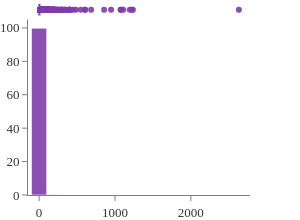
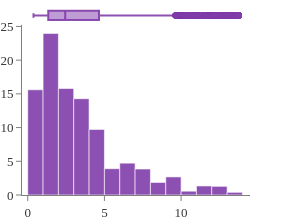

In [102]:
gen.next('dual')

**Наблюдения:**  

- В столбце с суммой заказов 51 нулевое значение (меньше 1%)
- Сумма заказа варируется от 0 до 2633.28 у.е.
- В основном заказы совершаются в диапазоне от 1.22 до 4.89 у.е.
- Сумма заказа в 2633.28 у.е. является выбросом

In [103]:
gen.next(only_summary=True)

Values,50 415 (100%),
Missing,---,
Distinct,36 523 (72%),
Duplicates,13 892 (28%),
Zeros,---,
Negative,---,
RAM (Mb),<1 Mb,


**Наблюдения:**  

- В таблице с заказами 72% уникльных пользователей.

#####  Таблица costs (информацию о расходах на маркетинг)

Загружаем данные и задаем типы данных для столбцов, где это возможно.

In [104]:
dtype = {'source_id': 'category'}
df_costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv', dtype=dtype
                , parse_dates=['dt'], date_format='%Y-%m-%d')
df_costs.rename(columns={'dt': 'promo_date', 'costs': 'promo_costs'}, inplace=True)
df_costs.sample(5, random_state=7)

,source_id,promo_date,promo_costs
1770,5,2018-04-16,139.51
660,2,2018-03-25,125.00
1782,5,2018-04-28,81.28
1352,4,2018-02-19,164.76
1308,4,2018-01-06,301.00


In [105]:
gen = pagri_data_tools.info_gen(df_costs)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
2 542,3,0,---,---


In [106]:
gen.next()

First date,2017-06-01 00:00:00,,Zeros,---,,Years missing,0%,
Last date,2018-05-31 00:00:00,,Missing,---,,Months missing,0%,
Values,2 542 (100%),,Distinct,364 (14%),,Weeks missing,0%,
RAM (Mb),<1 Mb,,Duplicates,2 178 (86%),,Days missing,<1%,


**Наблюдения:**  

- В таблице с расходами на рекламные компании есть попущенные дни, но их мало (меньше 1%)


Values,2 542 (100%),,Max,1 788.28,,Avg,129.48,,16.25 <1%
Missing,---,,95%,470.72,,Mode,---,,16.81 <1%
Distinct,2 396 (94%),,75%,170.06,,Range,1 787.74,,57.07 <1%
Duplicates,146 (6%),,Median,77.3,,iQR,148.12,,18.37 <1%
Zeros,---,,25%,21.95,,std,156.3,,6.35 <1%
Negative,---,,5%,7.39,,kurt,9.71,,10.32 <1%
RAM (Mb),<1 Mb,,Min,0.54,,skew,2.49,,23.74 <1%

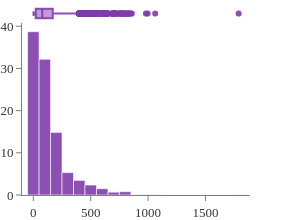

In [107]:
gen.next()

**Наблюдения:**  

- Расходы на рекламные компании варьируются от 0.54 до 1788.28 у.е.
- В основном расходы на рекламу лежат в диапазоне от 21.95 до 170.06 у.е.
- В расходах на рекламные компании значение 1788.28 у.е. является выбросом.

Values,2 542 (100%),,5 (14%)
Missing,---,,1 (14%)
Distinct,7 (<1%),,10 (14%)
Duplicated origin,2 535 (99.7%),,2 (14%)
Dupl (modify - origin),---,,3 (14%)
Empty,---,,4 (14%)
RAM (Mb),<1 Mb,,9 (14%)

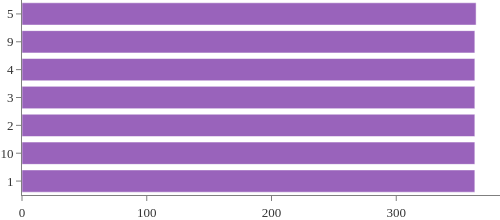

In [108]:
gen.next()

**Наблюдения:**  

- В таблице с расходами на рекламные компании 7 уникальных рекламных  компаний, а в табице с посещениями сайтов 9.  
Компании 6 и 7 отстутствуют в таблице с расходами на рекламные компании. Возможно это бесплатный трафик.


Соберем все датафреймы в словарь для удобства дальнейшей работы.

In [109]:
dfs = dict(
    visits = df_visits
    , orders = df_orders
    , costs = df_costs
)

#### Изучение дубликатов


Посмотрим на дубли во всем датафрейме


In [110]:
for key, df in dfs.items():
    display(f'{key} - {pagri_data_tools.check_duplicated(df)}')

'visits - no duplicates'

'orders - no duplicates'

'costs - no duplicates'

Посмотрим сколько у нас дублей в каждой колонке


In [111]:
for key, df in dfs.items():
    print(key)
    series_duplicated = pagri_data_tools.find_columns_with_duplicates(df)   

visits


device,359398 (100.00%)
session_end_dt,134640 (37.46%)
source_id,359391 (100.00%)
session_start_dt,135097 (37.59%)
uid,131231 (36.51%)


orders


order_dt,4424 (8.78%)
revenue,49266 (97.72%)
uid,13892 (27.56%)


costs


source_id,2535 (99.72%)
promo_date,2178 (85.68%)
promo_costs,146 (5.74%)


#### Изучение пропусков


Посмотрим на пропуски в каждом столбце

In [112]:
for key, df in dfs.items():
    print(key)
    series_duplicated = pagri_data_tools.find_columns_with_missing_values(df)   

visits
There are no missing values
orders
There are no missing values
costs
There are no missing values


Пропусков не обнаружено

#### Изучение выбросов


Изучим выбросы в каждом столбце.

Посмотрим что за заказы с суммой больше 1000 у.е.

In [113]:
df_orders[df_orders.revenue > 1000]

,order_dt,revenue,uid
23165,2017-12-10 13:04:00,"1,195.64",5539673724080479777
23244,2017-12-10 20:17:00,"2,633.28",5539673724080479777
24607,2017-12-17 18:06:00,"1,109.10",11149926373378902217
36522,2018-02-23 08:54:00,"1,236.28",11149926373378902217
36682,2018-02-24 09:25:00,"1,221.37",11149926373378902217
40386,2018-03-18 09:13:00,"1,073.11",11149926373378902217
47507,2018-05-16 19:53:00,"1,080.44",11149926373378902217


Подозрительные 2 пользователя.

Сгруппируем по пользователям и посмотрим топ пользователй по сумме заказа.

In [114]:
df_orders.groupby('uid')[['revenue']].sum().sort_values('revenue', ascending=False).head(5)

,revenue
uid,
5539673724080479777,"11,810.18"
11149926373378902217,"10,519.46"
17999372575896145244,"1,979.33"
6731421022966725351,"1,450.68"
3644482766749211722,"1,444.29"


**Наблюдения:**  

- 2 пользователя (id 5539673724080479777 и 11149926373378902217) имеют намного болше суммы заказов, чем остальные. Скорее всего это оптовики или перекупы.

Посмотрим на расходы на рекламные компании больше 1000

In [115]:
df_costs[df_costs.promo_costs > 1000]

,source_id,promo_date,promo_costs
902,3,2017-11-24,"1,788.28"
919,3,2017-12-11,"1,061.18"


**Наблюдения:**  

- Для рекламной компании с id 3 были две очень крупные суммы расходов 2017-11-01 и 2017-12-11.

Посмотрим на выбросы используя квантили.    
Выбросами будем считать значения, которые выходят за пределы 5 и 95 квантилей.

In [116]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_orders)

revenue,4476 (8.88%)
uid,5037 (9.99%)


**Наблюдения:**  

- Процент выбросов в выручке меньше 10%, это указывает на то, что выбросов не слишком много.

Посмотрим на распределены выбросы во времени

In [117]:
outliers_by_month = series_outliers.revenue.set_index('order_dt').resample('ME')[['revenue']].sum().reset_index()

In [118]:
config = dict(
    df = outliers_by_month
    , x = 'order_dt'
    , y = 'revenue'  
    , barmode = 'group'
    , orientation = 'v'
    , func = 'sum'
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort = True    
    , sort_axis = False    
    , sort_legend = True      
    , width = 1000
    , height = 450                                                                                                                         
)
fig = pagri_data_tools.bar(config)
fig = pagri_data_tools.plotly_default_settings(fig)
fig.update_layout(
    title_text = 'Суммарная стоимость заказа в зависимости от месяца'
    , yaxis_title_text = 'Стоимость заказа'
    , xaxis_title_text = 'Месяц и год'
)

**Наблюдения:**  

- Боьше всего суммарных выбросов в стоимости заказа было в декабре 2017 года

In [119]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df_costs)

promo_costs,256 (10.07%)


**Наблюдения:**  

- Процент выбросов в расходах на рекламные компании чуть больше 10%, это указывает на то, что выбросов не слишком много.

In [120]:
series_outliers.promo_costs.head(1)

,source_id,promo_date,promo_costs
30,1,2017-07-01,5.80


Посмотрим на распределены выбросы во времени

In [121]:
outliers_by_month = (
    series_outliers['promo_costs']
    .groupby([pd.Grouper(key='promo_date', freq='ME'), 'source_id'], observed=True)  # Группируем по месяцу и source_id
    .agg({'promo_costs': 'sum'})  # Суммируем promo_costs
    .reset_index()  # Сбрасываем индекс
)

In [122]:
config = dict(
    df = outliers_by_month
    , x = 'promo_date'
    , y = 'promo_costs'  
    , category = 'source_id'
    , barmode = 'group'
    , orientation = 'v'
    , func = 'sum'
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort = True    
    , sort_axis = False    
    , sort_legend = True      
    , width = 1000
    , height = 450                                                                                                                         
)
fig = pagri_data_tools.bar(config)
fig = pagri_data_tools.plotly_default_settings(fig)
fig.update_layout(
    title_text = 'Суммарная стоимость рекламной компании в зависимости от месяца'
    , yaxis_title_text = 'Стоимость рекламнойкомпании'
    , xaxis_title_text = 'Месяц и год'
    , legend_title_text = 'Компанния'
)

**Наблюдения:**  

- Боьше всего суммарные расходы в выбросах у компании с id 3.
- С ноября 2017 по март 2018 тратилось много денег на компаню с id 3.

Посмотрим на выбросы в разрезе компаний.

In [123]:
pagri_data_tools.analyze_anomaly_by_category(df, series_outliers, "by_category", "promo_costs", "source_id")

source_id,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
1,363,2,0.6%,0.8%,14.3%,-13.5%
10,363,70,19.3%,27.3%,14.3%,13.1%
2,363,1,0.3%,0.4%,14.3%,-13.9%
3,363,113,31.1%,44.1%,14.3%,29.9%
4,363,25,6.9%,9.8%,14.3%,-4.5%
5,364,2,0.5%,0.8%,14.3%,-13.5%
9,363,43,11.8%,16.8%,14.3%,2.5%


**Наблюдения:**
- Рекламная. компания с id 3 имеет больше выбросов в расходах, чем другие компании. Также много выбросов в расходах у компании с id 10, но меньше

#### Изучение отрицательных значений


Изучим отрицательные значения в каждом столбце.

In [124]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_visits)

There are no negative values


In [125]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_orders)

There are no negative values


In [126]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df_costs)

There are no negative values


Отрицательные значения не обнаружены

#### Изучение нулевых значений


Изучим нулевые значения в каждом столбце.

In [127]:
series_negative = pagri_data_tools.find_columns_with_zeros_values(df_visits)

There are no zeros values


In [128]:
series_negative = pagri_data_tools.find_columns_with_zeros_values(df_orders)

revenue,51 (0.10%)


Посмотрим на нули в стоимости заказа

In [129]:
series_negative.revenue.head()

,order_dt,revenue,uid
1802,2017-06-22 18:19:00,0.00,17030528792926543083
2787,2017-07-07 15:54:00,0.00,10281425020415612933
4783,2017-08-02 14:54:00,0.00,184148767273119549
5095,2017-08-09 14:48:00,0.00,5603453646174104178
5863,2017-08-23 13:43:00,0.00,5603453646174104178


Посмотрим есть ли зависимость от пользователей

In [130]:
series_negative.revenue.groupby('uid')[['revenue']].count().sort_values('revenue', ascending=False).head(10)

,revenue
uid,
2037345392173160982,12
5603453646174104178,6
8277558335454815700,6
4927261749585088199,4
5570343171257035973,4
2883839899480223178,2
184148767273119549,1
10281425020415612933,1
15254206642996645755,1


**Наблюдения:**  

- У пользователя с id 2037345392173160982 больше всего нулей в стоимости заказа.

In [131]:
series_negative = pagri_data_tools.find_columns_with_zeros_values(df_costs)

There are no zeros values


### Промежуточный вывод


- В столбце с суммой заказов 51 нулевое значение (меньше 1%)
- В таблице с расходами на рекламные компании 7 уникальных рекламных  компаний, а в табице с посещениями сайтов 9.  
Компании 6 и 7 отстутствуют в таблице с расходами на рекламные компании. Возможно это бесплатный трафик.
- Сумма заказа в 2633.28 у.е. является выбросом
- В расходах на рекламные компании значение 1788.28 у.е. является выбросом.
- 2 пользователя (id 5539673724080479777 и 11149926373378902217) имеют намного болше суммы заказов, чем остальные. Скорее всего это оптовики или перекупы.
- Для рекламной компании с id 3 были две очень крупные суммы расходов 2017-11-01 и 2017-12-11.
- Процент выбросов в выручке меньше 10%, это указывает на то, что выбросов не слишком много.
- Боьше всего суммарных выбросов в стоимости заказа было в декабре 2017 года
- Процент выбросов в расходах на рекламные компании чуть больше 10%, это указывает на то, что выбросов не слишком много.
- Боьше всего суммарные расходы в выбросах у компании с id 3.
- С ноября 2017 по март 2018 тратилось много денег на компаню с id 3.
- Рекламная. компания с id 3 имеет больше выбросов в расходах, чем другие компании. Также много выбросов в расходах у компании с id 10, но меньше
- У пользователя с id 2037345392173160982 больше всего нулей в стоимости заказа.
- В дате окончания сессии последняя дата попала на следующий месяц, нужно это учесть при расчете метрик.
- В дате окончания сессии есть пропуски в днях, но совсем мало (меньше 1%)
- В дате начала сессии есть пропуски в днях, но совсем мало (меньше 1%)
- В таблице с логами о посещении сайта 63% уникльных пользователей.
- Пользователей с девайсами desktop 73%, пользователей с девайсами touchpad 27%
- В таблице визитов 9 униклальных источников перехода на сайт
- Источники 6 и 7 очень редко встречаются
- В дате заказа последняя дата попала на следующий месяц, нужно это учесть при расчете метрик.
- В дате заказа есть пропущенные дни, но их мало (меньше 1%)
- Сумма заказа варируется от 0 до 2633.28 у.е.
- В основном заказы совершаются в диапазоне от 1.22 до 4.89 у.е.
- В таблице с заказами 72% уникльных пользователей.
- В таблице с расходами на рекламные компании есть попущенные дни, но их мало (меньше 1%)
- Расходы на рекламные компании варьируются от 0.54 до 1788.28 у.е.
- В основном расходы на рекламу лежат в диапазоне от 21.95 до 170.06 у.е.

## Предобработка данных


### Предварительная фильтрация данных


В дате окончания сессии и в дате заказа есть данные за июнь 2018 года.  
Чтобы даты во всех таблицах имели одинаковые границы, обрежем дату в окончании сессии и дате заказа от 2017-06-01 до 2018-06-01.

In [132]:
df_visits = df_visits[(df_visits.session_end_dt > '2017-06-01') & (df_visits.session_end_dt < '2018-06-01')]

In [133]:
gen = pagri_data_tools.info_gen(df_visits, column='session_end_dt', mode='column')
gen.next()

First date,2017-06-01 00:02:00,,Zeros,---,,Years missing,0%,
Last date,2018-05-31 23:59:00,,Missing,---,,Months missing,0%,
Values,359 388 (100%),,Distinct,224 749 (63%),,Weeks missing,0%,
RAM (Mb),5,,Duplicates,134 639 (37%),,Days missing,<1%,


In [134]:
df_orders = df_orders[(df_orders.order_dt > '2017-06-01') & (df_orders.order_dt < '2018-06-01')]

In [135]:
gen = pagri_data_tools.info_gen(df_orders, column='order_dt', mode='column')
gen.next()

First date,2017-06-01 00:10:00,,Zeros,---,,Years missing,0%,
Last date,2018-05-31 23:56:00,,Missing,---,,Months missing,0%,
Values,50 414 (100%),,Distinct,45 990 (91%),,Weeks missing,0%,
RAM (Mb),1,,Duplicates,4 424 (9%),,Days missing,<1%,


### Обработка выбросов


В столбце с суммой заказов 51 нулевое значение (меньше 1%).  
Так как этих значений мало, то удалим их, чтобы не мешали анализу.

In [136]:
df_orders.shape[0]

50414

In [137]:
df_orders = df_orders[df_orders.revenue != 0]
df_orders.shape[0]

50363

In [138]:
pagri_data_tools.check_zeros_value_in_df(df_orders)

,zeros


### Промежуточный вывод


- Обрезали данные, чтобы все даты были от 2017-06-01 до 2018-06-01.
- Удалили 51 нулевое значение (меньше 1%) в столбце с суммой заказа.

## Обогащение данных и создание новых переменных

### Создание новых числовых переменных

Создадим новую числовую переменную - длительность сессии в минутах.

In [139]:
df_visits.columns

Index(['device', 'session_end_dt', 'source_id', 'session_start_dt', 'uid'], dtype='object')

In [140]:
df_visits['session_duration'] = (df_visits.session_end_dt - df_visits.session_start_dt) / np.timedelta64(1, 'm')

Values,359 388 (100%),,Max,711,,Avg,10.72,,1 (15%)
Missing,---,,95%,38,,Mode,1,,0 (10%)
Distinct,312 (<1%),,75%,14,,Range,757,,2 (10%)
Duplicates,359 076 (99.9%),,Median,5,,iQR,12,,3 (7%)
Zeros,35 794 (10%),,25%,2,,std,16.62,,4 (6%)
Negative,2 (<1%),,5%,0,,kurt,81.26,,5 (5%)
RAM (Mb),5,,Min,-46,,skew,5.74,,6 (4%)

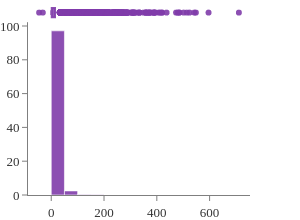
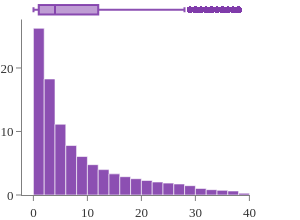

In [141]:
gen = pagri_data_tools.info_gen(df_visits, column='session_duration', mode='column')
gen.next('dual')

2 Отрицательных значения. Посмотрим на эти строки.

In [142]:
df_visits[df_visits.session_duration < 0]

,device,session_end_dt,source_id,session_start_dt,uid,session_duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-32.00
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-46.00


Это явно ошибка, удалим эти строки.

In [143]:
df_visits.shape[0]

359388

In [144]:
df_visits = df_visits[~(df_visits.session_duration < 0)]

In [145]:
df_visits.shape[0]

359386

Values,359 386 (100%),,Max,711,,Avg,10.72,,1 (15%)
Missing,---,,95%,38,,Mode,1,,0 (10%)
Distinct,310 (<1%),,75%,14,,Range,711,,2 (10%)
Duplicates,359 076 (99.9%),,Median,5,,iQR,12,,3 (7%)
Zeros,35 794 (10%),,25%,2,,std,16.62,,4 (6%)
Negative,---,,5%,0,,kurt,81.27,,5 (5%)
RAM (Mb),5,,Min,0,,skew,5.74,,6 (4%)

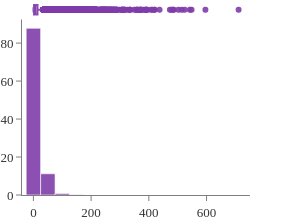
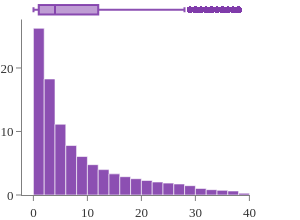

In [146]:
gen = pagri_data_tools.info_gen(df_visits, column='session_duration', mode='column')
gen.next('dual')

**Наблюдения:**  

- В длительности сессии есть 10% нулевых значений.
- В длительности сессии есть 2 отрицательных значения.
- Длительность сессии варьируется от 0 минут до 711 минут.
- В основном длительность сессии длиться от 2 до 14 минут.

Посмотрим на длительнсоть сессий в разрезе пользователей

In [147]:
df_visits[df_visits.session_duration == 0].groupby('uid')[['session_duration']].count().sort_values('session_duration', ascending=False).head(10)

,session_duration
uid,
12869801667763685675,57
3263486045884611639,36
10246903932085021612,23
15087669361906245158,23
9019681082555518724,19
6803848156077244893,19
11255648391090536411,18
8056418121947262981,17
3644482766749211722,17


**Наблюдения:**  

- У пользователя с id 12869801667763685675 боьше всего сессий с длительнсотью 0, но не существенно.

Посмотрим в разрезе устройства

In [148]:
df_visits[df_visits.session_duration == 0]['device'].value_counts()

device
desktop    23689
touch      12105
Name: count, dtype: int64

Посмотрим в разрезе источника трафика

In [149]:
df_visits[df_visits.session_duration == 0]['source_id'].value_counts()

source_id
4     10898
3      9025
5      7385
2      4158
1      1975
9      1297
10     1054
6         1
7         1
Name: count, dtype: int64

Существенных аномалий в записях с длительнстью сессии в 0 минут не обнаружено. Скорее всего это очень короткие сессии.

### Категоризация данных


Создадим новую категориальную переменную - является ли сессия нулевой.

In [150]:
df_visits['is_zero_session'] = df_visits.apply(lambda x: 'да' if x['session_duration'] == 0 else 'нет', axis=1)

In [151]:
df_visits['is_zero_session'].value_counts()

is_zero_session
нет    323592
да      35794
Name: count, dtype: int64

Создадим новую категориальную переменную из стоимости заказа.

Посмотрим на квантили в столбце с суммой заказа.

In [152]:
pagri_data_tools.quantiles_columns(df_orders.revenue)

Max,2 633.28
95,13.75
75,4.89
50,2.5
25,1.22
5,0.37
Min,0.01


Сделаем следующие категории

- Дешевые: Заказы ниже Q1   
- Средние: Заказы между Q1 и Q3  
- Дорогие: Заказы выше Q3  

In [153]:
labels = ['Дешевые', 'Средние', 'Дорогие']
bins = [-np.inf, 1.22, 4.89, np.inf]

In [154]:
df_orders['revenue_cat'] = pagri_data_tools.create_category_column(df_orders.revenue, labels=labels, bins=bins)
df_orders['revenue_cat'].value_counts(dropna=False)

revenue_cat
Средние    25516
Дешевые    12824
Дорогие    12023
Name: count, dtype: int64

Создадим новую категориальную переменную из расходов на рекламную компанию.

Посмотрим на квантили в столбце с суммой заказа.

In [155]:
pagri_data_tools.quantiles_columns(df_costs.promo_costs)

Max,1 788.28
95,470.72
75,170.06
50,77.3
25,21.95
5,7.39
Min,0.54


Сделаем следующие категории

- Дешевые: Заказы ниже Q1   
- Средние: Заказы между Q1 и Q3  
- Дорогие: Заказы выше Q3  

In [156]:
labels = ['Дешевые', 'Средние', 'Дорогие']
bins = [-np.inf, 21.95, 170.06, np.inf]

Если нужно пропуски заменить, то добавляем параметр `fillnavalue='не укаазано'`

In [157]:
df_costs['promo_costs_cat'] = pagri_data_tools.create_category_column(df_costs.promo_costs, labels=labels, bins=bins)
df_costs['promo_costs_cat'].value_counts(dropna=False)

promo_costs_cat
Средние    1270
Дешевые     636
Дорогие     636
Name: count, dtype: int64

Для даты начала сессии создадим новую категориальную переменную в формате месяц год.

In [158]:
# Словарь для замены месяцев
months_translation = {
    'Jan': 'Янв',
    'Feb': 'Фев',
    'Mar': 'Мар',
    'Apr': 'Апр',
    'May': 'Май',
    'Jun': 'Июн',
    'Jul': 'Июл',
    'Aug': 'Авг',
    'Sep': 'Сен',
    'Oct': 'Окт',
    'Nov': 'Ноя',
    'Dec': 'Дек'
}
# Получаем отдельно месяц и год
months = df_visits['session_start_dt'].dt.strftime('%b').astype('category').cat.reorder_categories(list(months_translation.keys()), ordered=True)
years = df_visits['session_start_dt'].dt.strftime('%y')
months_years = pd.concat([months, years], axis=1)
months_years.columns = ['month', 'year']
# Создаем список уникальных (год, месяц) и сортируем
unique_months = months_years.drop_duplicates().sort_values(by=['year', 'month'])

# Создаем список для порядка
month_year_order = []

# Формируем month_year_order на основе уникальных (год, месяц)
for _, row in unique_months.iterrows():
    year = row['year']
    month = row['month']
    month_year_order.append(f"{months_translation[month]}'{str(year)[-2:]}")

# Заменяем месяцы и соединяем с годом
df_visits['session_start_dt_month_year'] = months.astype(str).map(months_translation) + "'" + years
df_visits['session_start_dt_month_year'] = df_visits['session_start_dt_month_year'].astype('category')
df_visits['session_start_dt_month_year'] = df_visits['session_start_dt_month_year'].cat.reorder_categories(month_year_order, ordered=True)

Для даты заказа создадим новую категориальную переменную в формате месяц год.

In [159]:
# Словарь для замены месяцев
months_translation = {
    'Jan': 'Янв',
    'Feb': 'Фев',
    'Mar': 'Мар',
    'Apr': 'Апр',
    'May': 'Май',
    'Jun': 'Июн',
    'Jul': 'Июл',
    'Aug': 'Авг',
    'Sep': 'Сен',
    'Oct': 'Окт',
    'Nov': 'Ноя',
    'Dec': 'Дек'
}
# Получаем отдельно месяц и год
months = df_orders['order_dt'].dt.strftime('%b').astype('category').cat.reorder_categories(list(months_translation.keys()), ordered=True)
years = df_orders['order_dt'].dt.strftime('%y')
months_years = pd.concat([months, years], axis=1)
months_years.columns = ['month', 'year']
# Создаем список уникальных (год, месяц) и сортируем
unique_months = months_years.drop_duplicates().sort_values(by=['year', 'month'])

# Создаем список для порядка
month_year_order = []

# Формируем month_year_order на основе уникальных (год, месяц)
for _, row in unique_months.iterrows():
    year = row['year']
    month = row['month']
    month_year_order.append(f"{months_translation[month]}'{str(year)[-2:]}")

# Заменяем месяцы и соединяем с годом
df_orders['order_dt_month_year'] = months.astype(str).map(months_translation) + "'" + years
df_orders['order_dt_month_year'] = df_orders['order_dt_month_year'].astype('category')
df_orders['order_dt_month_year'] = df_orders['order_dt_month_year'].cat.reorder_categories(month_year_order, ordered=True)

Для даты рекламной компании создадим новую категориальную переменную в формате месяц год.

In [160]:
# Словарь для замены месяцев
months_translation = {
    'Jan': 'Янв',
    'Feb': 'Фев',
    'Mar': 'Мар',
    'Apr': 'Апр',
    'May': 'Май',
    'Jun': 'Июн',
    'Jul': 'Июл',
    'Aug': 'Авг',
    'Sep': 'Сен',
    'Oct': 'Окт',
    'Nov': 'Ноя',
    'Dec': 'Дек'
}
# Получаем отдельно месяц и год
months = df_costs['promo_date'].dt.strftime('%b').astype('category').cat.reorder_categories(list(months_translation.keys()), ordered=True)
years = df_costs['promo_date'].dt.strftime('%y')
months_years = pd.concat([months, years], axis=1)
months_years.columns = ['month', 'year']
# Создаем список уникальных (год, месяц) и сортируем
unique_months = months_years.drop_duplicates().sort_values(by=['year', 'month'])

# Создаем список для порядка
month_year_order = []

# Формируем month_year_order на основе уникальных (год, месяц)
for _, row in unique_months.iterrows():
    year = row['year']
    month = row['month']
    month_year_order.append(f"{months_translation[month]}'{str(year)[-2:]}")

# Заменяем месяцы и соединяем с годом
df_costs['promo_date_month_year'] = months.astype(str).map(months_translation) + "'" + years
df_costs['promo_date_month_year'] = df_costs['promo_date_month_year'].astype('category')
df_costs['promo_date_month_year'] = df_costs['promo_date_month_year'].cat.reorder_categories(month_year_order, ordered=True)

### Расчет метрик


Сгруппируем данные по месяцам и объеденим таблицы

In [163]:
df_visits.head(1)

,device,session_end_dt,source_id,session_start_dt,uid,session_duration,is_zero_session,session_start_dt_month_year,user_first_month,is_new_user
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.00,нет,Дек'17,Дек'17,True


In [ ]:
# Находим первый месяц для каждого клиента
df_visits['user_first_month'] = df_visits.groupby('uid')['session_start_dt_month_year'].transform('min')
# Теперь мы можем определить новых клиентов
df_visits['is_new_user'] = df_visits['user_first_month'] == df_visits['session_start_dt_month_year']


In [173]:
# Сначала отфильтруем новых пользователей
new_users_cnt = df_visits[df_visits['is_new_user']].groupby('session_start_dt_month_year', observed=True).agg(
    new_user_cnt=('uid', 'nunique')
)

# Затем сгруппируем все данные
df_visits_monthly = df_visits.groupby('session_start_dt_month_year', observed=True).agg(
    session_cnt=('uid', 'count'),
    mau=('uid', 'nunique'),
    total_session_len=('session_duration', 'sum'),
    avg_session_len=('session_duration', 'mean')
)

# Объединим результаты
df_visits_monthly = df_visits_monthly.join(new_users_cnt, how='outer')
df_visits_monthly.index.name = 'month_year'

In [174]:
df_visits_monthly.head(5)

,session_cnt,mau,total_session_len,avg_session_len,new_user_cnt
month_year,,,,,
Июн'17,16505,13259,"165,056.63",10.00,13259
Июл'17,17828,14183,"179,657.58",10.08,13140
Авг'17,14355,11631,"140,940.72",9.82,10181
Сен'17,23907,18975,"237,950.53",9.95,16704
Окт'17,37903,29692,"388,181.10",10.24,25977


In [176]:
# Находим первый месяц для каждого покупателя
df_orders['buyer_first_month'] = df_orders.groupby('uid')['order_dt_month_year'].transform('min')
# Теперь мы можем определить новых покупателей
df_orders['is_new_buyer'] = df_orders['buyer_first_month'] == df_orders['order_dt_month_year']

In [177]:
# Сначала отфильтруем новых пользователей
new_buers_cnt = df_orders[df_orders['is_new_buyer']].groupby('order_dt_month_year', observed=True).agg(
    new_buer_cnt=('uid', 'nunique')
)

df_orders_monthly = df_orders.groupby('order_dt_month_year', observed=True).agg(
    orders_cnt = ('uid', 'count')
    , buyers = ('uid', 'nunique')
    , total_revenue = ('revenue', 'sum')
    , avg_order_value = ('revenue', 'mean')
)
df_orders_monthly = df_orders_monthly.join(new_buers_cnt, how='outer')
df_orders_monthly.index.name = 'month_year'

In [178]:
df_orders_monthly.head(5)

,orders_cnt,buyers,total_revenue,avg_order_value,new_buer_cnt
month_year,,,,,
Июн'17,2353,2022,"9,557.49",4.06,2022
Июл'17,2362,1983,"12,539.47",5.31,1922
Авг'17,1803,1471,"8,758.78",4.86,1369
Сен'17,3383,2748,"18,345.51",5.42,2579
Окт'17,5677,4673,"27,987.70",4.93,4340


In [179]:
df_costs_monthly = df_costs.groupby('promo_date_month_year', observed=True).agg(
    promo_cnt = ('source_id', 'count')
    , promo_cnt_unq = ('source_id', 'nunique')
    , total_promo_costs = ('promo_costs', 'sum')
    , avg_promo_costs = ('promo_costs', 'mean')
)
df_costs_monthly.index.name = 'month_year'

In [77]:
df_costs_monthly.head(5)

,promo_cnt,promo_cnt_unq,total_promo_costs,avg_promo_costs
month_year,,,,
Июн'17,210,7,"18,015.00",85.79
Июл'17,217,7,"18,240.59",84.06
Авг'17,217,7,"14,790.54",68.16
Сен'17,210,7,"24,368.91",116.04
Окт'17,217,7,"36,322.88",167.39


In [180]:
df_visits_monthly.shape[0]

12

In [181]:
df_orders_monthly.shape[0]

12

In [182]:
df_costs_monthly.shape[0]

12

In [183]:
df_monthly = df_visits_monthly.join(df_orders_monthly, how='outer')

In [184]:
df_monthly = df_monthly.join(df_costs_monthly, how='outer')

In [185]:
df_monthly = df_monthly.reset_index()

In [186]:
df_monthly.shape[0]

12

Убедимся, что у нас нет NA

In [187]:
df_monthly.isna().sum()

month_year           0
session_cnt          0
mau                  0
total_session_len    0
avg_session_len      0
new_user_cnt         0
orders_cnt           0
buyers               0
total_revenue        0
avg_order_value      0
new_buer_cnt         0
promo_cnt            0
promo_cnt_unq        0
total_promo_costs    0
avg_promo_costs      0
dtype: int64

Расчитаем разные метрики для будущего анализа

In [188]:
df_monthly.head(1)

,month_year,session_cnt,mau,total_session_len,avg_session_len,new_user_cnt,orders_cnt,buyers,total_revenue,avg_order_value,new_buer_cnt,promo_cnt,promo_cnt_unq,total_promo_costs,avg_promo_costs
0,Июн'17,16505,13259,"165,056.63",10.00,13259,2353,2022,"9,557.49",4.06,2022,210,7,"18,015.00",85.79


Доля новых пользователей и доля новых покупателей покупателей

In [189]:
df_monthly['new_users_ratio'] = df_monthly['new_user_cnt'] / df_monthly['mau']
df_monthly['new_buers_ratio'] = df_monthly['new_buer_cnt'] / df_monthly['buyers']

Доля покупателей из всех пользователей и доля новых покупателей из всех новых пользователей

In [190]:
df_monthly['buers_users_ration'] = df_monthly['buyers'] / df_monthly['mau']
df_monthly['new_buers_users_ration'] = df_monthly['new_buer_cnt'] / df_monthly['new_user_cnt']

Стоимость привлечения одного покупателя

In [ ]:
df_monthly['cac'] = (df_monthly.total_promo_costs / df_monthly.new_buer_cnt).round(2)

Стоимость привлечения одного пользователя

In [ ]:
df_monthly['cpa'] = (df_monthly.total_promo_costs / df_monthly.new_user_cnt).round(2)

Среднее количество покупок на одного клиента.

In [ ]:
df_monthly['apc'] = (df_monthly.orders_cnt / df_monthly.buyers).round(2)

Средний чек

In [ ]:
df_monthly['aov'] = (df_monthly.total_revenue / df_monthly.orders_cnt).round(2)

Выручка с одного пользователя

In [ ]:
df_monthly['arpu'] = (df_monthly.total_revenue / df_monthly.mau).round(2)

Выручка с одного покупателя

In [ ]:
df_monthly['arppu'] = (df_monthly.total_revenue / df_monthly.buyers).round(2)

Валовая прибыль

In [199]:
df_monthly['margin'] = df_monthly.total_revenue  - df_monthly.total_promo_costs

Маржинальность

In [200]:
df_monthly['margin_pct'] = (df_monthly.margin / df_monthly.total_revenue).round(2)

Подготовим датафреймы для когортного анализа

Таблица визитов

In [202]:
df_visits.head(1)

,device,session_end_dt,source_id,session_start_dt,uid,session_duration,is_zero_session,session_start_dt_month_year,user_first_month,is_new_user
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.00,нет,Дек'17,Дек'17,True


In [233]:
df_visits['tmp_user_first_month'] = df_visits.groupby('uid')['session_start_dt'].transform('min')

In [ ]:
df_visits['cohort_lifetime'] = (
    (df_visits['session_start_dt'].dt.year - df_visits['tmp_user_first_month'].dt.year) * 12 +
    (df_visits['session_start_dt'].dt.month - df_visits['tmp_user_first_month'].dt.month)
)

Убедимся, что нет отрицательных значений

In [239]:
(df_visits['cohort_lifetime'] < 0).sum()

np.int64(0)

In [242]:
df_visits.drop('tmp_user_first_month', axis=1, inplace=True)

Таблица заказов

In [244]:
df_orders.head(1)

,order_dt,revenue,uid,revenue_cat,order_dt_month_year,buyer_first_month,is_new_buyer
0,2017-06-01 00:10:00,17.00,10329302124590727494,Дорогие,Июн'17,Июн'17,True


In [245]:
df_orders['tmp_buyer_first_month'] = df_orders.groupby('uid')['order_dt'].transform('min')

In [246]:
df_orders['cohort_lifetime'] = (
    (df_orders['order_dt'].dt.year - df_orders['tmp_buyer_first_month'].dt.year) * 12 +
    (df_orders['order_dt'].dt.month - df_orders['tmp_buyer_first_month'].dt.month)
)

Убедимся, что нет отрицательных значений

In [247]:
(df_orders['cohort_lifetime'] < 0).sum()

np.int64(0)

In [248]:
df_orders.drop('tmp_buyer_first_month', axis=1, inplace=True)

Сгруппируем данные по месяцу когорты и lifetime

In [282]:
df_visits_cohort_by_month = df_visits.rename(columns={'user_first_month': 'cohort_month_year'}).groupby(['cohort_month_year', 'cohort_lifetime'], observed=True).agg(
    visits_cnt=('uid', 'nunique'),
)

In [283]:
df_orders_cohort_by_month = df_orders.rename(columns={'buyer_first_month': 'cohort_month_year'}).groupby(['cohort_month_year', 'cohort_lifetime'], observed=True).agg(
    buyers_cnt=('uid', 'nunique'),
    revenue=('revenue', 'sum'),
    orders_cnt=('uid', 'count'),
)

Объеденим таблицы в одну

In [277]:
df_visits_cohort_by_month.shape[0]

78

In [278]:
df_orders_cohort_by_month.shape[0]

78

In [285]:
df_cohort = df_visits_cohort_by_month.join(df_orders_cohort_by_month, how='outer').reset_index()

In [280]:
df_cohort.shape[0]

78

In [289]:
df_cohort = df_cohort.merge(df_costs_monthly.reset_index(), left_on='cohort_month_year', right_on='month_year', how='outer').drop('month_year', axis=1)

Убедимся, что у нас нет NA

In [290]:
df_cohort.isna().sum()

cohort_month_year    0
cohort_lifetime      0
visits_cnt           0
buyers_cnt           0
revenue              0
orders_cnt           0
promo_cnt            0
promo_cnt_unq        0
total_promo_costs    0
avg_promo_costs      0
dtype: int64

Все хорошо.  
Теперь расчитаем метрики для когорт

In [291]:
df_cohort.head(1)

,cohort_month_year,cohort_lifetime,visits_cnt,buyers_cnt,revenue,orders_cnt,promo_cnt,promo_cnt_unq,total_promo_costs,avg_promo_costs
0,Июн'17,0,13259,2022,"9,557.49",2353,210,7,"18,015.00",85.79


Стоимость привлечения одного покупателя

In [ ]:
df_monthly['cac'] = (df_monthly.total_promo_costs / df_monthly.new_buer_cnt).round(2)

Стоимость привлечения одного пользователя

In [ ]:
df_monthly['cpa'] = (df_monthly.total_promo_costs / df_monthly.new_user_cnt).round(2)

Среднее количество покупок на одного клиента.

In [ ]:
df_monthly['apc'] = (df_monthly.orders_cnt / df_monthly.buyers).round(2)

Средний чек

In [ ]:
df_monthly['aov'] = (df_monthly.total_revenue / df_monthly.orders_cnt).round(2)

Выручка с одного пользователя

In [ ]:
df_monthly['arpu'] = (df_monthly.total_revenue / df_monthly.mau).round(2)

Выручка с одного покупателя

In [ ]:
df_monthly['arppu'] = (df_monthly.total_revenue / df_monthly.buyers).round(2)

Валовая прибыль

In [ ]:
df_monthly['margin'] = df_monthly.total_revenue  - df_monthly.total_promo_costs

Маржинальность

In [ ]:
df_monthly['margin_pct'] = (df_monthly.margin / df_monthly.total_revenue).round(2)

- $\text{ROMI} = \frac{\text{LTV}}{\text{CARC}} * 100$



Способы расчета LTV  
ВАЖНО: 
LTV расчитываются на определнном периоде, поэтому нужно это всегда уточнять и ARPU тогда должна быть расчитана на этот же период и  
lifetime долен иметь изменрение такого же периода (то есть если ARPU за месяц, то lifetime в месяцах)  
Лучше всего считать LTV через когорты, тогда нам не нужен lifetime  
Расчет через валовую прибыль
- $\text{LTV} = \text{margin rate} * \frac{\text{Total revenue by period}}{\text{total users by period}}$
- $\text{LTV} = \text{margin rate} * \text{ARPU} * \text{Lifetime}$
- $ \text{LTV} = \text{(ARPU - CAC + CRC)} * \text{Lifetime} $

Расчет через выручку:
- $\text{LTV} = \frac{\text{Total revenue by period}}{\text{total users by period}}$
- $\text{LTV} = \text{ARPU} * \text{Lifetime}$
- $\text{LTV} = \text{AOV} * \text{APC}$

Чтобы рассчитать lifetime, нужно узнать Churn Rate за определенный период, который будет размерностью lifetime, то есть период должен быть таким же как в расчете ARPU

$\text{Lifetime} = \frac{1}{\text{Churn Rate}} $  

Ltv лучше считать по когортам  
И когда составили матрицу когорт, то уже успреднить каждый месяц жизни и потом суммировать все месяца (именно так, вертикально усредняем, горизонтально суммируем)  

В иделае считать не просто среднее значение по когортам, а средневзвешенное.  
То есть если мы хотим посчитать среднее значение по всем когортам какого-то показателя, то мы не просто суммируем все значения в когортах и делим на  
число когорт, мы взвешиваем какждое значение когорты.  
Есить 2 способа
- умножать значение каждой когорты на ее размер и потом всю эту сумму разделить на общий размер всех когорт
- сразу дать веса каждой когорты, то есть определить долю каждой когорты в общем.  
Берем размер когорты и делим на размер всех когорт. И потом умнажаем значения в когортах на коэффиценты.  

ВАЖНО  
для всех метрик, считаем среднее (или мода или медиана) за все время, изображаем на графике во времени и в идеале строим когортный анализ.  
То есть у нас должно быть аггрегированное за все время значение, разбитое во времени и разбитое по когортам.

Продуктовые метрики, которые полезно считать  
- MAU, DAU, WAU  
за весь период, динамика во времени по периодам
- сколько раз за день пользователи в среднем заходят на сайт. график, отражающий изменения метрики во времени.
    Сколько сессий в день можно нести два смысла
    - сколько всего сессий в среднем проходит в день  
    покажет среднюю нагрузку в день на сервис
    - сколько в среднем совершает сессий 1 пользователь в день  
    покажет поведение посетителей на платформе (как часто  они в днеь появляются)   
- сколько времени пользователи проводят на сайте. график во времени  
- продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. График во времени  
    - рисуем гистограму или violine
    - вычисляем все средние меры и выбираем наиболее подходящую из них и приводим число  
    Если среднее, мода и медина примерно равны, то можно брать среднее.  
    Но если они разные, то нужно подумать какое лучше взять и обосновать выбор.  
    Как всегда пишем причины, почему выбрали эту метрику.  
    Тут важно какой вопрос, если вопрос сколько обычно длиться одна сессия, и у нас ненормальное распределение длительностей сессий,  
    то среднее значение будет некоректно, так как обычно в данном случае это будет мода, так как среднее будет  
    смещенно вправо, елси у нас экспоненциальное распределение времени.  
    Вот этот момент очень важен.  
    Так как среднее введет в заблуждение.  
    Обычно сессия длить как раз модальное значение.  
- Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт.  
    - расчитываем retention rate, для этого
    - необходимо сделать когортный анализ по времени (по месяцам или неделям или дням и тп)  
    Чтобы сделать когортный анализ, мы по одной оси откладываем даты, а по второй оси откладываем номер месяца,  
    таким образом мы получим для одной даты разные значения retention rate черзе 1, 2, 3, 4 и так далее месяцев  
    Будет динамика по месяцам от стартового месяца.  
    Также дополнительно можно сделать тепловую карту времени и какой-нибудь каетгории (например возраст, пол польователей),  
    retention rate можно считать просто относительно предыдущего месяца (тут уже не будет динамики по месяцам)

    Ответ среднее значение, тепловая карта выводы  
    Для описания тенденции, берем среднее значение за первый период (после нулевого) и смотрим как дальше относительно этого значения  
    идут изменения

Метрики электронной коммерции
- сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. график во времени   
    Нужно ответить на 2 вопроса
    - Через сколько времени после первого посещения пользователь совершил первую покупку?  
    - В какую по счету сессию люди начинают покупать?
    Ответом будет среднее значение метрики (обоих вариантов) и выводы  
    Дополнительно можно попробовать построить бар чар и посмотреть эти значения в разрезе какой-то категории
- AOV. Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. график во времени
    то есть сколько в среднем один покупатель делает покупок за период  
    Для выбора периода нужно понять какой период нам лучше подходит, например если у нас данные за год,  
    то период 6 месяцев будет нормально. 
    - Суммируем все покупки за все периоды и делим на количество покупателей, которое было в нулевой период  
    Берем суммирем все покупки за первые 6 месяцев всех пользователей и   
    делим на общее число пользователей в начале периода (в первый месяца)   
    Важно уточнение за какой период  
    Для расчета показателей за период X месяцев можно использовать только данные  
    - по когортам, которые взаимодействуют с компанией в течении X месяцев или более  
    - за первые X месяцев жизни когорт  
- Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени.
- Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике;
В финансовом менеджменте ответ на вопрос когда, также важен как ответ на вопрос сколько.  
Тут важно указывать за какой промежуток, так как LTV считается за период и еденица периода должна идти в ответе.    
Например, 3 y.e. это неверно    
правильно будет 3 y.e./год   
Тут у нас еденица расчета ltv это год     
Для выбора периода нужно понять какой период нам лучше подходит, например если у нас данные за год,  
то период 6 месяцев будет нормально. 
И нельзя сравнивать ltv за разные периоды.  
Если мы выбрали год, то мы берем отсечку год от первого сессии и считаем сколько всего люди все потратили за это время  
и делим на количество людей в первый период.  
Очень частая ошибка считать сначала среднее по разным периодам (например среднее людей, которые прожили месяц, потом 2 и так далее),  
а потом усреднять эти значения.  
Тут нужно суммировать все доходы от всех и разделить на количество пользователей на старте.  
Когорты это хорошо, но их нужно считать отдельно и не выводить из них общее среднее для всех.    
Чтобы проверить правильно ли мы рассчитали LTV можно сравнить его с   
LTV = среднее число покупок за выбранный период на одного пользователя * средний чек   
До этого мы как раз посчитали среднее число покупок за период на одного пользователя и средний чек.  

Маркетинговые метрики  
- Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени;
(значит нужно изучить как данные по расходам в всего изменяются во времени)  
Ответ среднее занчение, график, выводы (можно сравнить с общей прибылью и можно cac сравнить с ltv)  
график затрат на маркетинг не только по периодам, но ещё график затрат по источникам (бар плот и heatmap)  
и сделать вывод какие источники самые затратные, какие менее затратные  
- Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках
Важно, что метрика рассчитывается по покупателям, поэтому нам нужно использовать только тех, кто совершил хотя бы одну покупку  
Сложность в том, что пользователи заходят с разных источников.  
Возможные решения этой проблемы    
    - вычислить в какую именно сессию была совершена покупка и привязать ее именно к этому источнику (с которого эта сессия произошла)
    - привязать пользователя к тому источнику, с которого он чаще заходил  
    - привязать пользователя к источнику, с которого он первый раз зашел на сервис     
    этот метод предпочтительнее    
Ответ - среднее значение метрики в целом и по разным источникам  
таблица средних значений метрики по источника или/и график (бар плот)
выводы
-  Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени.  
Окупаемость считаем не от выручки, а от LTV (в целом и по источникам)  
Не забывать про сопостовляемый период (как с LTV)
Ответ - среднее значение метрики, таблица средних значений метрики по источникам и графики (бар плот и heatmap)

ВАЖНО  
Все метрики нужно посмотреть в разрезе разных параметров (которые есть, например, по платформам, полу пользователй и другим категориям) и сделать выводы,  
о том как параметр влияет на каждую метрику. Посмотреть как они меняются во времени.

ВАЖНО  
Если нам нужно выбрать главные метрики, которые нужно изучить, если у нас слишком много метрик или мало времени,  
то собираем все метрики в датафрейм и строим матрицу корреляций.  
И берем те метрики, которые имеют наибольшую корреляцию с целевой метрикой, чаще всего выручкой (60-70+)

ВАЖНО  
Выводы должны не просто описывать графики, а содержать рекомендации.  
И общий вывод должен включить все метрики, которые мы получили (числами).  
И сделать вывод основываясь на всех полученных метриках, а не просто сказать, что вот этот канал лушче других.  
То есть в какой канал рекламы лучше направить больше выручки, какая категория больше приносит выручки (можно сделать предоложения почему). 
И итоговый вывод это всегда рекомендация что можно сделать, чтобы улучшить сервис, основываясь на полученных данных.  

ВАЖНО  
Сначал смотрим общую картину. Общую выручку, общие расходы, рентабельность и другие бизнес метрики, а потом уже спускаемся к детальным метрикам.  
Хорошая проверка, это когда мы сначала просто смотрим выручку и расходы и получаем вывод о окупаемости сервиса.  
А потом когда разобрали по метрикам, то результат должен сходиться, не должно быть так, что выручка - расходы говорит, что все плохо,  
а выводы по метрикам, что все хорошо.  

Что можно дополнительно посчитать

- накопительная сумма продаж    
- остаток на балансе (количество пришедших едениц минус количество ушедших)   
- накопительный остаток   
- создание категориальной переменной новый / постоянный клиент. Считаем для каждого клиента дату первой покупки,  если текущая дата  
равна минимальной, то это новый. Также можно добавить, что если прошло больше N дней, то тоже новый.

#### Производные метрики

Тут пишем разные производные метрики из имеющихся переменных.  
Тут будут те метрики, которые нельзя отнести к остальным подразделам метрик. 

#### Ключевые показатели эффективности (KPI)

Финансовые KPI

- Выручка — общий доход от продаж товаров или услуг.
- Прибыль — разница между доходами и расходами.
- Рентабельность — отношение прибыли к выручке или к активам.
- Коэффициент ликвидности — способность компании покрыть свои краткосрочные обязательства.
- Себестоимость продаж — общие затраты на производство товаров или услуг.

Операционные KPI

- Производительность — количество продукции, произведенной за единицу времени.
- Уровень запасов — количество товаров на складе в данный момент времени.
- Время выполнения заказа — время, необходимое для обработки и доставки заказа.
- Качество продукции — процент бракованных изделий или уровень удовлетворенности клиентов.

Маркетинговые KPI

- Стоимость привлечения клиента (CAC) — затраты на привлечение одного клиента.
- Конверсия — процент пользователей, совершивших целевое действие (например, покупку).
- Возврат на инвестиции в маркетинг (ROMI) — прибыль, полученная от маркетинговых кампаний.
- Трафик на сайт — количество посетителей на сайте.

KPI для HR

- Текучесть кадров — процент сотрудников, покинувших компанию за определенный период.
- Уровень удовлетворенности сотрудников — измеряется через опросы и анкетирования.
- Среднее время найма — время, необходимое для заполнения вакансии.
- Процент выполнения целей сотрудников — доля сотрудников, достигших своих KPI.

KPI для обслуживания клиентов

- Уровень удовлетворенности клиентов (CSAT) — измеряется через опросы после обслуживания.
- Чистый промоутерский балл (NPS) — измеряет лояльность клиентов.
- Время ответа на запросы — среднее время, необходимое для ответа на запросы клиентов.
- Процент решенных проблем с первого обращения — доля запросов, решенных при первом контакте.

#### Финансовые метрики.

- Выручка
- Прибыль
- Рентабельность
- Операционные расходы
- Кэш-флоу

#### Маркетинговые метрики

- Стоимость привлечения клиента (CAC)
- Пожизненная ценность клиента (LTV)
- Конверсия
- ROI (возврат на инвестиции)
- Охват и вовлеченность

#### Операционные метрики.

- Эффективность процессов
- Время выполнения заказа
- Уровень запасов
- Производительность труда
- Уровень дефектов

#### Метрики пользовательского опыта.

- Удовлетворенность клиентов (CSAT)
- Чистый промоутерский балл (NPS)
- Время на сайте
- Показатель отказов
- Количество активных пользователей

#### Метрики продаж

- Объем продаж
- Средний размер сделки
- Темп роста продаж
- Доля рынка
- Уровень удержания клиентов

#### Метрики производительности

- Время выполнения задач
- Эффективность использования ресурсов
- Уровень производительности сотрудников
- Качество продукции
- Время простоя

#### Метрики веб-аналитики

- Посещения
- Уникальные посетители
- Время на странице
- Конверсии по каналам
- Источники трафика

#### Метрики социальных медиа

- Подписчики
- Вовлеченность (лайки, комментарии, репосты)
- Охват постов
- Темп роста подписчиков
- Анализ упоминаний бренда

#### Метрики HR

- Уровень текучести кадров
- Удовлетворенность сотрудников
- Время на заполнение вакансий
- Эффективность обучения
- Уровень вовлеченности сотрудников

#### Метрики качества

- Уровень удовлетворенности клиентов
- Количество жалоб
- Соответствие стандартам
- Время на исправление дефектов
- Показатели качества продукции

#### Метрики продукта

Финансовые метрики:

- Выручка: общий доход от продаж.
- LTV (Lifetime Value): пожизненная ценность клиента, показывающая, сколько дохода приносит клиент за все время взаимодействия с продуктом.
- CAC (Customer Acquisition Cost): стоимость привлечения одного клиента.
- ARPU (Average Revenue Per User): средний доход на пользователя.

Метрики вовлеченности:
    
- DAU (Daily Active Users): количество уникальных пользователей, которые взаимодействуют с продуктом ежедневно.
- WAU (Weekly Active Users): количество уникальных пользователей за неделю.
- MAU (Monthly Active Users): количество уникальных пользователей за месяц.
- Retention Rate: процент пользователей, которые продолжают использовать продукт после определенного периода.

Метрики конверсии:

- Conversion Rate: процент пользователей, которые выполняют целевое действие (например, покупка, регистрация).
- Churn Rate: процент пользователей, которые перестают использовать продукт за определенный период.

Метрики качества:

- NPS (Net Promoter Score): показатель лояльности клиентов, основанный на их готовности рекомендовать продукт.
- CSAT (Customer Satisfaction Score): уровень удовлетворенности клиентов продуктом.
Метрики использования:

- Average Session Duration: среднее время, проведенное пользователем в приложении или на сайте.
- Bounce Rate: процент пользователей, которые покидают сайт после просмотра только одной страницы.

Метрики роста:

- GMV (Gross Merchandise Value): общий объем продаж товаров через платформу.
- Monthly Recurring Revenue (MRR): ежемесячный повторяющийся доход, особенно важен для подписочных моделей.

#### Экономические метрики


> тут будут расчеты экономических метрик


> Если расчет метрик является важным аспектом вашего исследования и требует подробного описания, то создание отдельной главы будет лучшим решением.  
> Если в этом разделе будет немного расчетов, то можно сделать расчеты метрик разделом предобработки данных


> Расчитываем разные метрики на основе имеющихся данных и тех, которыми смогли обогатить данные


> Важно следить за количеством недель в году, если мы создаем столбец месяца.  
> Проверять чтобы у нас не появлялась неделя дополнительная, из за того, что мы захватили предыдущий год


Финансовые метрики:

- Выручка: общий доход от продаж товаров или услуг.
- Прибыль: разница между выручкой и затратами, показывающая финансовый результат деятельности.
- Рентабельность: отношение прибыли к выручке, выраженное в процентах, что позволяет оценить эффективность использования ресурсов.

Метрики затрат:

- Себестоимость: общие затраты на производство и продажу товаров или услуг.
- Операционные расходы: затраты, связанные с основной деятельностью компании, включая зарплаты, аренду и коммунальные услуги.

Метрики ликвидности:

- Текущая ликвидность: отношение текущих активов к текущим обязательствам, показывающее способность компании покрывать краткосрочные долги.
- Коэффициент быстрой ликвидности: более строгий показатель ликвидности, исключающий запасы из текущих активов.

Метрики эффективности:

- ROE (Return on Equity): доходность собственного капитала, показывающая, насколько эффективно компания использует средства акционеров.
- ROA (Return on Assets): доходность активов, отражающая, как эффективно используются все активы компании для генерации прибыли.

Метрики роста:

- Темпы роста выручки: процентное изменение выручки за определенный период, показывающее динамику бизнеса.
- Темпы роста прибыли: процентное изменение прибыли, что позволяет оценить финансовую устойчивость и развитие компании.

Метрики инвестиционной привлекательности:

- P/E (Price to Earnings Ratio): соотношение цены акции к прибыли на акцию, используемое для оценки стоимости компании.
- EV/EBITDA (Enterprise Value to Earnings Before Interest, Taxes, Depreciation, and Amortization): показатель, который помогает оценить стоимость компании относительно ее операционной прибыли.

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_start_` где начало и `_end_` где конец

Не забываем удалить метки `_start_` и `_end_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

## Визуализация взаимосвязей переменных


Сначала пишем ИИ все наши таблицы и названия переменных, которые были и которые создали.  
И спрашиваем какие зависимости нужно изучить. Пишем напиши подробный список.  
Далее это вставляем в temp.ipynb и когда будем изучать то смотрим.  
И в конце убедиться, что мы это все изучили. Если нет, то отедльно строим графики для этого.  
Также в процессе сами думаем какие зависимости стоит изучить,  
когда ИИ нам напишет список.  

ВАЖНО  
Смотрим и общую картину и по каждой нужно категории отедльно и делаем это за один проход, чтобы снова не проходить все данные.  
И в такой последовательности мы можем сравнить общую картину и по каждой категории отдельно и сделать более точные выводы.
В итоге будет график общей ситуации и далее графики по каждой категории.  
Причем нужно определить, что для нас важно, что нужно отобразить в любом случае, даже если нет явных зависимостей.  
А остальное сохраняем только то, что представляет интерес.  
Схема следующая
- Нужно выбрать важные категории и числовые переменные, которые мы хотим изучить отдельно.  
- Когда изучаем графики, то изучаем всю картину целиком и затем изучаем отдельно каждую категорию.

ВАЖНО  
Когда мы анализируем данные и у нас в категории болше 10 значений, то по возможности нужно брать топ 5-10 значений на графиках.  
Нас в основном интересует топ 5-10 значений, а не все значения.  
Бывают исключения, но чаще всего нам интересно оп 5-10 значений.  
И тогда анализировать графики будет проще. И выводы можно будет сделать точнее.  

ВАЖНО  
Если у нас было несколько таблиц и мы создали общую из нескольких, то изучать нужно общую.  
Или как минимуму общую тоже, так как будет ошибкой, изучить только исходые таблицы.  

### Сравнительный анализ распределений числовых переменных по категориям

Берем каждую числовую переменную и строим накладывающиеся гистограммы для всех категорий.  
И так повторяем для всех числовых переменных.

ВАЖНО  
Строим накладывющиеся гистограммы или боксплты / violin для всех числовых переменных.  
Нужно изучить все числовые переменные и сравнить их распределения и сделать выводы какие лучше и прочее.

ВАЖНО   
смотрим на выбросы  
Мы могли при изучении отдельных столбцов не заметить их, если заметили, то возвращаемся в изучение и предобработку и изучаем их дополнительно

ВАЖНО  
категориальные переменные могут быть не только в отдельном столбце.  
Категориальная переменная может быть разбита на разные столбцы.  
Например, оценка пользователей и оценка критиков могут быть в отдельных столбцах.  
Нужно при предобработке это не забыть привести  к категориальному типу, чтобы далее анализировать.

ВАЖНО  
Если создали категориальную переменную есть пропуск или нет, то тут по ней тоже смотрим накладывающиеся гистограммы

ВАЖНО  
наложенные гистограммы нужно сделать не только для категориальных переменных.  
У нас могут быть 2 числовые переменные, которые мы решили не соединятьь через melt  
Но они имеют похожую природу. Для таких случаев тоже нужно сделать гистограммы.

ВАЖНО  
Когда посторили боксплоты
- сравниваем медианы, квартили, делаем выводы
- сравниваем количество выбросво
- сравниваем размахи внутри квартилей
- сравниваем iqr
- смотрим пересекаются ли irq у разных категорий, если не пересекаются, то это говорит о существенном отличии.

Сормируем словарь для подписей осей и названий графиков.

In [ ]:
titles_for_axis = dict(
    # numeric column ['Именительный падеж', 'для кого / чего']
    avg_score = ['Средняя оценка', 'средней оценки']
    # categorical column ['Именительный падеж', 'для кого / чего']
    # Распределение долей по городу и тарифу с нормализацией по городу
    , genre = ['Жанр', 'жанра']
)

Строим накладывающиеся гистограммы для нужных числовых переменных в рарзрезе нужных категорий   
в `histograms_stacked` есть `mode` со значениями`step` и `normal`  
Если у нас категория имеет мало значений, то можно normal  
Если у нас категория имеет много значений, то step  

Если у нас числовая переменная разбита на несколько столбцов, то сначала мелтим ее

In [ ]:
# Применяем melt для преобразования данных
value_vars = ['critic_score', 'user_score']
melted_df = pd.melt(df, # id_vars=df.columns.difference(value_vars), 
                    value_vars=value_vars,
                    var_name='score_type', value_name='score')
# Словарь для замены значений
region_mapping = {
    'critic_score': 'Оценка критиков',
    'user_score': 'Оценка пользователей',
}
# Замена значений в столбце region
melted_df['score_type'] = melted_df['score_type'].replace(region_mapping).astype('category')

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=20
    , line_width=3
    , opacity = 0.6
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

Строим накладывающиеся боксплоты для нужных числовых переменных в рарзрезе нужных категорий

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n='all'
)
pagri_data_tools.boxplots_stacked(config=config, titles_for_axis=titles_for_axis)

Строим накладывающиеся violin для нужных числовых переменных в рарзрезе нужных категорий

In [ ]:
config = dict(
    df = df
    , cat_var = 'genre'
    , num_var = 'avg_score'
    , top_n='all'
)
pagri_data_tools.violins_stacked(config=config, titles_for_axis=titles_for_axis)

### Исследование корреляционных связей

Следим за правильным порядком переменных полученных из времени

Чтобы подготовить title_for_axis, пишем ии так  

запомни - total_images = ['Число фотографий', 'числа фотографий', 0], - тут первый элемент списка это общая форма и с большой буквы, второй элемент это форма первого элемента при ответе на вопрос Чего и третий элеент списка это род элемента (0 - средний род, 1 - мужской род, 2 женский род) понятно?  

и далее даем список нужных названий колонок в таком виде 

Для корреляций достаточно просто указать название без рода и склонения

Сормируем словарь для подписей осей и названий графиков.

In [ ]:

titles_for_axis= dict(
        total_images = 'Число фотографий',
        last_price = 'Цена',
        total_area = 'Общая площадь',
        rooms = 'Число комнат',
        ceiling_height = 'Высота потолков',
        floors_total = 'Всего этажей',
        living_area = 'Жилая площадь',
        floor = 'Этаж'
)

ВАЖНО  
проверить, что все категориальные переменные по прежнему имеют категориальный тип, чтобы при анализе они не поетрялись

ВАЖНО  
Изучаем корреляцию на всем периоде данных и на отдельных периодах (например последние N лет, месяцев, дней)  
Также нужно посмотреть корреляцию в определенные периоды, для этого разбить нарпимер, на кварталы, сезоны или по другим категориям.  
И посмотреть корреляции в каждом срезе.  

In [ ]:
df.dtypes

In [ ]:
for key, df in dict(
            df_users = df_users
            , df_calls = df_calls
            , df_messages = df_messages
            , df_internet = df_internet
            , df_tariffs = df_tariffs
            , df_calls_full = df_calls_full
            , df_messages_full = df_messages_full
            , df_internet_full = df_internet_full
            , df_by_userid_month = df_by_userid_month
            , df_arpu = df_arpu).items():
    print(key)
    display(df.dtypes)

>Топ n значений одного столбца по значениям в другом
>Сделать функцию, чтобы в столбцах, где бльше 20 уникльных значений посмотреть топ n значений по другой колонке.  
>Например, топ 10 покупателей по сумме покупок и прочее.  
>Идея в том, что если  в столбце до 20 уникальных значений, то мы проанализируем комбинации с другими стобцами на графиках.  
>А вот если у нас столбец не числовой и в нем больше 20 уникальных значений, то на графике мы не сможем понять топ n.

>Изучаем топ n значений в категориальных столбцах датафрейма, где значений больше порогового, по значению в столбце value_column.  
>Тут можно делать разные топы, использовать разные функции.  
>Задача изучить то, что мы не сможем изучить на графиках из-за болшого количества занчений в категориальной переменной,  
>поэтому мы берем топ n значений.  

In [ ]:
gen = pagri_data_tools.top_n_values_gen()
next(gen)

>Чтобы сравнить метрики между собой мы можем
- использовать корреляционный анализ (Пирсена, Спирмена, Кенделла)


>`heatmap_corr(df)`

( r = 1 ): Полная положительная линейная зависимость.  
( 0.7 < r < 1 ): Сильная положительная линейная зависимость.  
( 0.3 < r \leq 0.7 ): Умеренная положительная линейная зависимость.  

Если числовых переменных не много и они входят на один график, то просто строим график

ВАЖНО  
Посмотреть корреляцию в каждой категории категориальной переменной.  
То есть задача взять категориальную переменную и посмотреть корреляцию для каждой категории отедльно.  
Это важно, так как во всех категориях суммарно может затеряться зависимости.  
Не нужно все их помещать в отчет, наша задача найти важные существенные зависимости и их уже пометсить в отчет.  
Но чтобы их найти, нужно смотреть не только на картину в целом, но изучить корреляции в каждой категории.

Посмотрим на коэффициенты корреляции между числовыми переменными.

In [ ]:
pagri_data_tools.heatmap_corr(df, titles_for_axis=titles_for_axis)

Лучше лишние ячейки убирать, если есть возможность 

In [ ]:
pagri_data_tools.heatmap_corr(df_by_userid_month[['sessions_per_day', 'calls_per_day']])

Если нужно быстро просмотреть, то проганяем в цикле

In [ ]:
for key, df in dict(
            df_users = df_users
            , df_calls = df_calls
            , df_messages = df_messages
            , df_internet = df_internet
            , df_tariffs = df_tariffs
            , df_calls_full = df_calls_full
            , df_messages_full = df_messages_full
            , df_internet_full = df_internet_full
            , df_by_userid_month = df_by_userid_month
            , df_arpu = df_arpu).items():
    print(key)
    display(pagri_data_tools.heatmap_corr(df))

Если переменных много и нужно разделить на части, то используем эту функцию 

In [ ]:
gen = pagri_data_tools.heatmap_corr_gen(df, part_size=10, titles_for_axis=titles_for_axis)
next(gen)

>Использование регрессии и случайного леса для определения влияния переменных  

>Коэффициенты регрессии позволяют оценить влияние каждой переменной на целевую переменную, учитывая влияние других переменных,  
>в то время как важные компоненты в случайном лесе позволяют оценить важность каждой переменной для предсказания целевой переменной.

>Используем регрессиию

>Чтобы построить регрессию и посмотреть стат значимость и коэффициенты удобно использовать модуль statsmodel

>VIF означает Variance Inflation Factor (Фактор инфляции дисперсии). Это статистическая метрика,   
>используемая для обнаружения мультиколлинеарности (сильной корреляции) между предикторами (фичами) в линейной регрессии.

>Обычно, VIF интерпретируется следующим образом:
>
- VIF < 5: слабая мультиколлинеарность
- 5 ≤ VIF < 10: умеренная мультиколлинеарность
- VIF ≥ 10: сильная мультиколлинеарность

>
>Смотрим R2 (коэффициент детерминации)
- использовать коэффициенты у регресси
>Мы строим регрессию и смотрим, у каких метрик больше коэффициенты. Таким образом мы поймем какие метрики сильнее зависят с целевой.  
>Важно, чтобы независимые переменные некоррелировали по отдельности и вместе (мультиколлиниарность).  
>По отдельности смотрим матрицу корреляции.  
>Чтобы определить коррелириуют ли вместе, береме независимые переменные,  
>и перебираем их выбирая одну из них целевой и смотрим R2.  
>Если R2 большой, то значит эта метрика (которая целевая на этом шаге) хорошо описывается другими и ее можно выбросить.
>Также не забываем поправки на гетероскедостичность (HC0, HC1, HC2, HC3) в статпакетах.  
>Нам нужно ответить на следующие вопросы
>    - Влияет ли метрика на целевую?
>    Оцениваем коэффициенты в уравнении регресси у каждой метрики.  
>    - Как влияет метрика на целевую?
>    Смотрим R2 (коэффициент детерминации). И определяем какая часть целевой переменной определяется независимыми метриками.  
>    - Коэффициенты при метриках в уравнении статистически значим? При какаом уровне значимости?
>    Смотрим в стат пакете p value для каждого коэффициента, что нам говорит значим ли этот коэффициент.  
>    То есть мы не просто смотрим его абсолютное значение, а учитываем p value.   
>    - Дайте содержательную интерпретацию коэффицентам?
>    При увеличении метрики k на 1, целевая метрика увеличивается на $b_{k} * 1$
>    То есть нужно перевести коэффициенты в реальное сравнение, насколько увелчисться целевая метрика при изменении определенной метрики на 1
>    - Найдите 95 процентный доверительный интервал.
>    В стат пакете смотрим значение и оно говорит, что если мы многократно повторим ноши вычисления с новыми данными, то 95 процентов наших  
>    полученных коэффицентов будут лежать в этом диапазоне.  

>Строим модель и изучаем результат  
>`linear_regression_with_vif`

In [ ]:
pagri_data_tools.linear_regression_with_vif()

>Испльзовать коэффициенты у классификацию    
>Строим случайный лес какие метрики сильнее всего влияют на решения модели.   
>`plot_feature_importances_classifier`   
>`plot_feature_importances_regression`

>Тут нужно подумать как использовать категориальные переменные тоже   
>Нужно их перевести в one hot encoding или подобное, чтобы также проверить силу их влияния на целевую перменную

In [ ]:
titles_for_axis = dict(
    debt = 'долга'
    , children = 'Кол-во детей'
    , age = 'Возраст'
    , total_income = 'Доход'
)
title = 'График важности признаков для предсказания цены'
pagri_data_tools.plot_feature_importances_classifier(df, target='debt', titles_for_axis=titles_for_axis, title=title)
pagri_data_tools.plot_feature_importances_regression()

>На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез

> используем быблиотеку `shap`, чтобы определить метрики, которые лучше других помогают предсказывать целевую перемменную

Добавить в dash app возможность сохранять код для ячейки с фильтром (срезом данных).  
То есть у нас есть фильтр, мы хотим посмотреть срез данных и фильтруем данные.  
И если увидели что-то важное, то мы сохраняем код для создания графика с этими x, y, category и фильтром.  
То есть в коде сначала будет фильтрация датафрейма и потом создание графика в 2 строки.  

важно мы не пишем все наблюдения, а только те, которые могут быть важны для анализа, то есть мы смотрим, задаем вопросы данным и   
и если ответ важен, то мы записываем наблюдения)

ВАЖНО   
Когда мы видим таблицу или график, то мы придумываем вопросы к результату.  
Все возможные вопросы (как, почему, зачем, сколько, как долго, быстро ли, медленно ли, важно ли это, из-за чего это и прочие вопрсоы)
И отвечая на эти вопросы мы получаем наблюдения и выводы
И чтобы задавать правильные вопросы, мы должны сначала подумать о физике параметров, которые мы видим.

Если у нас много значений в переменной, то мы агрегируем данные и можем построить бары.  
Но если мы агрегируем данные по переменной, в которой много значений и нам это нужно.  
То мы не сможем построить бары, и тогда мы строим гистограмму. То есть мы берем, например, для каждой заправки считаем среднее время заправки и так как у нас много заправок,  
но мы хотим визуализировать среднее время по ним, и не агрегировать по другому параметру, то мы можем испльзовать гистограмму.  
В данном случае гистограмма своего рода агрегация в бины, то есть мы получаем как бы новую переменную из бинов, в каждом бине будет агрегированы данные.  
Это работает, когда нам нужно просто посмотреть колечество, так как в бинах будет количество. Таким образом мы получаем сколько у нас заправок имеют определенное среднее вермя заправки.


> Про размер графиков  
> Стандартный размер графиков width=600, height=400  
> Для более сложных графиков, когда требуется больше места для отображения данных, можно использовать размеры width=800, height=600 или width=1000, height=800


> Сравнивать количество элементов нужно в абсолютных и относительных величинах.  
> Когда мы сравниваем только в абсолютных величинах, мы не учитываем размеры групп.  
> В одной группе может быть элементов больше чем в другой и тогда сравнение будет не совсем точным.  
> Если у нас 2 категориальные переменные, то мы можем сравнивать отностельные величины  
> по одной переменной, а можем по другой.  
> Это как сравнивать суммарный возраст в группах, это не дает полной картины и мы сравниваем средний возраст,  
> чтобы размер группы не влиял.


> ВАЖНО
> Анализ графиков и выводы для них должны полностью перекрывать постановку задачи и цель.  
> Это значит, что если цель проанализировать зависимость наличия долга, то мы в идеале должны проанализировать  
> влиянеие каждой переменной на наличие долга (числовой и категориальной)  
> Кончено нужно проанализировать все возможные зависимости.  
> Но все зависимости с переменной в постновке задачи мы обязаны проверить и дать выводы. И о наличии и об отсутствие.  
> Важные выводы делаем не только о наличие интересных моментов, но и об отсутствие.


> Сначала раздел графиков  
> На основе графиков формируются гипотезы (например, у нас у мужчин зп больше)
> И после раздела графиков идет раздел проверки гипотез. Тут мы првоеряем разные гипотезы новые и те, что увидели на графиках.  
> Это правильная последовательность сначала изучили графики и потом на основе их сформировали гипоетзы
> Перед разделом про графики идет раздел с корреляцией и поиском главных компонет случайного леса.  
> Мы выбиарем переменную, для которой мы далее хотим посмотреть разыне зависимости и указываем ее целевой для сучайного леса  
> И смотрим какие фичи сильнее влияют.  
> И теперь можем построить графики с целевой перменно и этими главными фичами и в выводе можно указать про то что это важные компоненты случаного леса


> На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез


### Изучение зависимостей между числовыми переменными


Построим графики рассеяния и изучим зависимости.


ВАЖНО  
Изучаем зависимости между числовыми переменными без фильтрации и с фильтрацией.  
То есть нужно взять и пройти по каждой категории и посмотреть на зависимости в каждой категории.  
Возможно даже в комбинации категорий.  
Так как в общей картинке зависимости могут затеряться.

ВАЖНО смотрим на выбросы  
Мы могли при изучении отдельных столбцов не заметить их, если заметили, то возвращаемся в изучение и предобработку и изучаем их дополнительно

In [ ]:
pairs = {('total_images', 'last_price'): None, ('total_images', 'floors_total'): {'total_images': [-2.15, 22.45], 'floors_total': [0.51, 28.54]}, ('total_images', 'kitchen_area'): {'total_images': [-1.04, 28.44], 'kitchen_area': [-0.6, 59.26]}, ('total_images', 'parks_nearest'): {'total_images': [np.int64(0), np.int64(50)], 'parks_nearest': [np.float64(1.0), np.float64(3190.0)]}, ('total_images', 'ponds_around3000'): {'total_images': [np.int64(0), np.int64(50)], 'ponds_around3000': [np.float64(0.0), np.float64(3.0)]}, ('total_images', 'living_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'living_total_ratio': [np.float64(0.02), np.float64(1.0)]}, ('total_images', 'kitchen_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'kitchen_total_ratio': [np.float64(0.03), np.float64(0.79)]}, ('total_images', 'price_per_sqm'): {'total_images': [np.int64(0), np.int64(50)], 'price_per_sqm': [np.int64(7962), np.int64(1907500)]}, ('last_price', 'living_area'): {'last_price': [np.int64(430000), np.int64(763000000)], 'living_area': [np.float64(2.0), np.float64(427.55)]}}
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3).show(config=dict(displayModeBar=False, dpi=200), renderer="png")
# если нужно интерактивый график, то
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3)

Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

ВАЖНО  
убираем лишние колонки, которые нам не нужно изучать, например, id, и другие числовые переменные, которые будут только тратить место в dash app

In [ ]:
df_by_userid_month.drop(['user_id', 'messages_included'], axis=1)

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.scatterplot_analysis_dash(df, "path/to/notebook/for/save")

### Изучение зависимостей между категориальными переменными


> Чтобы автоматически генерировались подписи осей и заголовок графика для категориальных, временных и числовых с категориальными зависимостейь
> , нужно заполшнить такой словарь.  
> Первый элемент списка - это подпись оси  
> Второй элемент списка - это как это название будет отображаться в заголовке графика  
> Для числовых столбцов также указывается род, чтобы правильно выбрать (Середнее, средний, средняя) (0 - средний род, 1 - мужской род, 2 - женский род)


ВАЖНО построить распределение количества по категориальным переменным без разбивки по другим категориям.  
То есть например, посмотреть количество новых пользователей по месяцам, по кородам и так далее.  
И так все количества, и не только категориальные.  
Это важно, так как по этим графикам будет видна общая динамика без разбивки на категории.  
И плюс всякие user_id и прочее в dash app не отображается, поэтому нужно это изучить отдельно.  

ВАЖНО  
Добавить возможность выбирать 1 col и 2 cols  как это в app dash числовые и категориальные  
Так как часто полезно посмотреть на распределение количества только в одной категории.

In [ ]:
f'Среднее / Медианное / Суммарное {numeric} в зависимости от {category} и {category}'  

ВАЖНО  
titles_for_axis далее будет один для всех разделов  
поэтому если нужно добавить, то возвращаемся и добавляем сюда, чтобы была одна переменная

Бывает полезно посмотреть сравнение по месяцам, дням, годам униклальных значений и всех занчений.  
Подумать есть ли у нас подобные ситуации, для которох можно постриоть такой график

In [ ]:
#Рассмотрим количество выпущенных игр за весь период наблюдений и сравним количество всего и уникальных игр
sum_un=df.pivot_table(index='year_of_release', values='name', aggfunc=lambda x: len(x.unique())) #Количество выпускаемых игр
sum_total=df.pivot_table(index='year_of_release', values='name', aggfunc='count') #Количество выпускаемых игр с учетом релиза на разных платформах
graph=sum_un.merge(sum_total, left_index=True, right_index=True)
fig = px.line(graph)
fig

Сормируем словарь для подписей осей и названий графиков.

In [ ]:
titles_for_axis = dict(
    # numeric column ['Именительный падеж', 'мменительный падеж с маленькой буквы', 'род цифорой']
    # (0 - средний род, 1 - мужской род, 2 - женский род[) (Середнее образовние, средний доход, средняя температура) )
    # для функций count и nunique пишем - Количество <чего / кого количество> - и также с маленькой буквы, цифра 0 в качестве рода
    age = ['Возраст', 'возраст', 1]
    , using_duration = ['Длительность использования', 'длительность использования', 2]
    , mb_used = ['Объем интернет трафика', 'объем интернет трафика', 1]
    , revenue = ['Выручка', 'выручка', 2]
    # categorical column ['Именительный падеж', 'для кого / чего', 'по кому чему']
    # Распределение долей по городу и тарифу с нормализацией по городу
    , city = ['Город', 'города', 'городу']
    , tariff = ['Тариф', 'тарифа', 'тарифу']
    , is_active = ['активный ли клиент', 'активности клиента', 'активности клиента']
)

Важно когда мы смотрем очередной график, то задавать не только вопросы к данным, но и думать как можно отфильтровать  
данные, чтобы сделать дополнительные полезные выводы.  
То есть мы фильтруем данные и потом эти графики поместим в раздел с анализом срезов.  

Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

Как правильно писать выводы для нормализации по col и row:
В dash app нормализация идет по значениям в легенде,   
Например, у нас по index - город, а по столбцам - тарифы.
- нормализация по index (в dash будет row)  
При нормализации по индексам вы получаете долю пользователей каждого тарифа в каждом городе относительно общего числа пользователей в этом городе.
то есть если по оси город, а в легенде название тарифа, то нормализация будет по тарифам.  
И мы сравниваем 
А если в легенде город, то нормализация идет по городам, и мы сравниваем по городам.  
И можно сделать такие выводы  
    - В Москве 60% пользователей выбирают тариф "Ультра", что указывает на его популярность среди москвичей.
    - В Санкт-Петербурге 70% пользователей предпочитают тариф "Смарт", что может говорить о том, что данный тариф более привлекателен для жителей этого города.
то ессть при нормализации по городу, мы получаем долю пользователей тарифа в городе.  
- нормализация по столбцам (в dash будет col)  
При нормализации по столбцам вы получаете долю пользователей каждого города для каждого тарифа относительно общего числа пользователей, выбравших этот тариф.
А когда мы нормализуем по тарифу, то мы получаем долю пользователей города в тарифе.      
    - Из всех пользователей, выбравших тариф "Ультра", 40% приходятся на Москву, что может указывать на то, что этот тариф пользуется спросом именно в этом городе.
    - Из всех пользователей, выбравших тариф "Смарт", 50% находятся в Санкт-Петербурге, что может свидетельствовать о том, что данный тариф более популярен среди петербуржцев.
- Нормализация по всем значениям (в dash all)    
При нормализации по всем значениям вы получаете долю пользователей каждого тарифа в каждом городе относительно общего числа пользователей всех тарифов в обоих городах.
    - В общем числе всех пользователей (Москва и Санкт-Петербург) 30% выбирают тариф "Ультра", что может указывать на его общую популярность.
    - Тариф "Смарт" составляет 20% от общего числа пользователей, что показывает, что он менее популярен по сравнению с тарифом "Ультра" на уровне всей выборки.

Сначала смотрим 1_cat, чтобы записать распределение по 1 категории.  
Не забываем делеть swap_cols чтобы изучить обе категориальные переменные.  
Записываем, если есть различия в долях в категории.  

ОЧЕНЬ ВАЖНО  
Если много значений и бары сливаютсю, то включаем heatmap  
ВАжно не забывать, что heatmap для этого и нужен.

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.category_analysis_dash(df, 'df', "path/to/notebook/for/save")

> Строим матрицу тепловой карты для категориальных переменных и изучаем зависимости  


Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.categorical_heatmap_matrix_dash(df, 'df', "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

> Посмотрим на распределение количества элементов между группами


> Нужно подумать как отобразить не только процент от всего количества, но и пороцент в группе  
> То есть у нас есть значение в ячейке, сумма всех, сумма по категории на оси x и сумма по категории на оси Y  
> Вот нужно как-то отобразить процент от суммы, процент от одной категории и от другой категории


In [ ]:
12 (0.5% of total, 20% of row, 15% of col) 

> Можно сделать кнопки, чтобы можно было подсветку делать внури колонок и строк


> Можно сделать кнопки (процент от общего) (процент от тут указывается название оси x) (аналогично для второй оси)


In [ ]:
pagri_data_tools.categorical_graph_analys_gen()

> Строим treemap  
> `treemap`  
> `treemap_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


ВАЖНО  
на treemap очень хорошо заметно выделяющиеся цепочки категорий по количеству.  
Важно посмотреть по 3 и более категорий в ряд,  
не нужно сильна всматриваться, задача заметить категории которые выделяются (будет явно больше прямоугольник)  
И если нашли выделяющиеся важные категории, то сохраняем график и делаем выводы.

In [ ]:
pagri_data_tools.treemap()

In [ ]:
app = pagri_data_tools.treemap_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим parallel_categories  
> `parallel_categories `  
> `parallel_categories_dash `
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.parallel_categories()

In [ ]:
app = pagri_data_tools.parallel_categories_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

> Строим Sankey  
> `sankey `  
> `sankey_dash`
>
> ```
> app = treemap_dash(df)
> if __name__ == '__main__':
>    app.run_server(debug=True)
> ```


In [ ]:
pagri_data_tools.sankey()

In [ ]:
app = pagri_data_tools.sankey_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

### Изучение зависимостей между числовыми и категориальными переменными


Построим графики для числовых переменных в разрезе категорий.

добавить слайдер как доп переменную и анимация будет сразу

In [ ]:
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000], width=900, height=500)
fig.show()

Важно когда мы смотрем очередной график, то задавать не только вопросы к данным, но и думать как можно отфильтровать  
данные, чтобы сделать дополнительные полезные выводы.  
То есть мы фильтруем данные и потом эти графики поместим в раздел с анализом срезов.  

> Можно добавить кнопку среднее и количество  
> Чтобы можно было посмотртеть распределение по количеству, когда смотрить среднее.


In [ ]:
_gen_ 

Добавить в hover количество элементов в группе,  
чтобы понимать размер группы.

Добавить возможность перескакивать комбинации.  
Если много колонок, то комбинаций очень много и часть может быть просто не нужна для анализа.  

Изучаем следующим образом  
- смотрим на график и определяем есть ли взаимодейсвие (то есть отличаются ли значения в разных группах, это будет видно как разная высота баров)
- если разницы в барах нет, или она минимальная, то сразу можно пропускать
- если разница есть, то думаем важна ли для нас ээта комбинация столбцов
- если нет, то пропускаем
- если да, то пишем наблюдения и сохраняем

Не забываем смотреть 1_cat чтобы изучить отдельную категорию.  
То есть график появлился, смотрим на обе категории и на числовую переменную и думаем, нужно ли нам по отдельности изучить  
каждую категориальную переменную c числовой. Если уже изучили, то не изучаем.
Нужно подумать как сохранять уже изученые комбинации, чтобы не повторяться (может в dash app добавить всплывающее окно, для графиков, для которых уже был вывод, что уже было)

ВАЖНО  
Если много переменных, и не все они нужны для анализа,  
то смотрим df.columns, выбираем нужные и в dash передаем датафрейм с нужными колонками.

ВАЖНО  
не забываем смотреть sum для переменных типа выручки

ВАЖНО  
id это такая же числовая переменная, как и все остальные, но ее нужно аггрегировать, используя  
`count` и `nunique`

ВАЖНО  
для графика heatmap   
важно смотреть по какой колоноке больше значений и ее делать по оси X  
Так как ширина графика больше высоты

ВАЖНО  
Если на графика 2 категориальной переменной, то хороший размер 1000 на 450 (width на height)  
Если на графике 1 категориальной переменной, то хороший размер 600 на 400 (width на height)

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.numeric_category_analysis_dash(df, 'df', "/home/pagri/git_repos/pagri-projects/quarto/projects/housing-ads-investigation/temp.ipynb")

### Анализ временных зависимостей


Изучим графики, представляющие различные временные переменные.


Это раздел нужен, чтобы изучить тредны, сезонность и определить какие категории уже свое отжили, а какие перспективные.  
Какие категории падают по продажам, может нужно с этим что-то сделать и так далее.
Смотрим на графики с временными зависимостями и отвечаем на такие вопросы:
- Есть ли категории, которые присутствуют не все время?
Например, у нас продажи игр и есть категория платформы, мы построили график суммарных продаж по платформам и по годам. И видим, что явно   
заметно, что платформа живет определенное время, так как есть пик продаж и потом продаж мало.
- Есить ли тренды, сезонность, циклы?
- Какие категории были популярны в прошлом, какие начинают становится популярными, какие показывают устойчивость долгое время
- Какие категории будут популяны ближайшее время исходя из того в какой-момент времени они находятся сейчас и какие результаты показывали в прошлом и показывают сейчас. 

ОЧЕНЬ ВАЖНО  
Обязательно смотрим heatmap для для всех числовых переменных в разрезе категорий по годам.  
Этот график отлично показывает участки, когда категория была активно, динамику во времени и прочее.  
По оси X идет время а по оси Y идет категория, и тогда каждая полоска это динами во времени, если например, у нас продажи,  
то будет четко видно где спад, а где подъем, когда мы подкрашиваем значения.

Проходим и из предыдущих разделов копируем все графики с временными переменными и вставляем сюда.

Когда мы хотим изучить верменную зависимость, то нам нуно создать новые переменные с обрезанными (trunc or round) значениям, чтобы можно было сгруппировать используя groupby or pivot_table  
по этой обрезанной переменной и применить функцию агрегации и построить график, например, среднее время заправки на азс по часам.  
Вот когда мы работаем с временем, нам нужно думать какие переменные создать, обрезая текущее время.


> Строим когортный анализ, если есть возможность


> Если у нас есть даты, то мы можем посмотреть не просто абсолютные значения на каждую дату какой-то метрики,  
> а посмотреть относительные значения относительно предыдущего значения.  
> Для этого нужно составить таблицу, в которой будет изменение в процентах относительно предыдущего значения.  
> И затем визуализировать для каждой даты динамику этого показателя


ВАЖНО  
Если у нас есть время, то нужно посмотреть среднее время жизни определенных продуктов и прочее.  
Тут важно, чтобы категории не жили все время, которое у нас есть в данных, иначе у всех будет одно время.  
Это нужно делатЬ, если у нас есть категориальная переменная, занчения которой не всегда присутствуют.
Например, у нас данные по годам продаж игр. Нужно взять продажи по годам и выбрать период, когда они активно продавались.  
Это можно сделать через квантили или через 2-3 std.  
Посчитать средене по всем играм.  
Также у нас могут быть категории, например, платформы, тогда мы можем сагрегировать по платформам и посмотреть среднее время жизни платформы. 


Построим график времени жизни платформы

In [ ]:
platform_lt = df.groupby('platform').agg({'year_of_release':'nunique'})
px.bar(platform_lt, x=platform_lt.index, y='year_of_release')

Посчитаем общее среднее время жизни платформы

In [ ]:
print('Среднее время жизни платформы', df.groupby('platform').agg({'year_of_release':'nunique'}).mean())

И так мы можем делать со всеми категориальными переменнми, если у нас есть временная переменная.  
Схема такая
- мы группируем по категорилаьной переменной и считаем уникльное количество нужных нам временных периодов.
- строим график
- считаем общее среднее время жизни

И далее мы получаем временной интервал (среднее время жизни), который мы можем использовать для фильтрации.  
То есть нам нужно определить перспективные направления в определенной категориальной перменной.  
У нас сейчас нарпимер, 2015 год. Мы выяснили что среднее время жизни категории 5 лет.  
Тогда мы смотрим сколько на момент 2015 года прожила каждая категория. И далее считаем сколько ей осталось ещё жить.  
Сортируем по времени оставшейся жизни. В итоге получаем топ переспективных категорий.

Общая схема такая
- Выбираем категориальную переменную, в которой нам нужно определить перспективные категории.
- Строим график для каждой категории ее вермени жизни. Делаем выводы.
- Считаем среднее время жизни платформ (в идеале если есть другие категории, которые разделют категории на общие, то использовать расчет внутри подгруп).
- Далее Берем актуальные на данный момент категории и считаем сколько они прожили к данному моменту.
- Вычитаем среднее время жизни всех платформ и строим график топ по оставшемуся времени жизни.
- Делаем выводы, какие категории будут лучше ближайшее время.

ВАЖНО  
Если нам нужно определить перспективные категории в будущем,  
то нужно использовать среднее время жизни категории. И взять период от текущего момента минус среднее время жизни.  
И изучить именно этот период. Так мы получим более точные результаты.  
Для выбранного периода строим данные по количеству проданных копий, например, по сумме выручки.   
Строим боксплоты или vilon рядом за этот временной период и сравниваем, какие категории дали лучше результаты.  
И делаем выводы.  
Таким образом важно изучить общие данные и данные за среднее время жизни категории отложенного от текущего момента назад.  

ВАЖНО  
Чтобы определить самую перспективную категорию, нужно взять отрезок времени от текущего минус среднее время жизни.  
И построить например, график общих продаж по годам в разрезе категории. Таким образом мы увидим у кого прибыль расте, а у кого падает.  
И так как мы значем среденее время жизни, то мы можем уже делать выводы о будущем.  


ВАЖНО  
Вообще очень важно на графиках, с временными зависимостями смотреть конечную дату и делать выводы, какие категории уже на спаде, а какие сейчас актуальны.    
Это можно понять по графику суммарных продаж по годам, суммарной выручки по годам, количествую новых пользователей по годам и так далее.  
Нужно делать, например, такие выводы:  
    Эти платформы относительно молоды (3-5 лет), свой пик они уже прошли и не показывают потенциальных перспектив роста продаж, но их продажи пока выше остальных и какое-то время они способны продержаться на плаву и заполнить нишу на рынке игровых платформ, ведь геймеры никуда не делись. Мы не видим платформ моложе либо с тенденцией роста к концу 2016 года, поэтому есть смысл сделать ставки на эти три: большинство крупных проектов подошли к своему завершению, и между ними и новыми разработками, которые возможно скоро появятся на рынке, будет явный провал, который надо переждать для "поддержания штанов"

Таким образом, смотрим на график (это моежт быть и бары, лини и heatmap в зависимости от количества категорий),  
и изучаем динамику. 
Пишем выводы, что данные категории уже не актуальны, что определенные категории набирают оброты, что другие категории показывают лучшую устойчивость..  
Например - 
- Жанр А был популярен до Х года, но последнее время потерял популярность, это видно по суммарным продажам и количеству новых пользователей.
- Жанр Б показвает устойчивый рост, что говрит о том, что он ещё будет определенное время популярным.
- Жанр В только появился на рынке и показывает хорошие результаты, то есть он может быть перспективным.
И так делаем выводы по каждой категории.  
Суть в том, чтобы проанализировать динамику во времени.  
Для этого и создается раздел анализ временных зависимостей, чтобы изучить тредны, сезонность и определить какие категории уже свое отжили, а какие перспективные.  
Какие категории падают по продажам, может нужно с этим что-то сделать и так далее.

ВАЖНО  
пройти просмотреть все графики и где нужно изменить тип на линии  
Если на графике динамика чего-то то линия лучше баров.  
Если идет сравнение то бары лучше.

ВАЖНО  
Пройти просмотреть все графики  
Где только 1 категориальная переменная сделать горизонтальную ориентацию

ВАЖНО  
Пройти просмотреть все графики и где нужно проставить числа над барами

### ВАЖНО

- Берем все датафреймы, которые анализировали.  
- И по очереди выводим все колонки, с указанием категориальная, числовая или другая.  
- Собираем все выводы от графиков. 
- И внимательно думаем, какие зависимости мы пропустили.  
- Строим их

In [ ]:
df_by_userid_month.dtypes

### Анализ срезов данных 

ВАЖНО  
Посмотреть графики для каждой категории в нужных категориальных переменных. 
Например, у нас категориальная переменная регион.  
Нужно посмотреть все зависимости для каждого региона отдельно и отобразить графики.  
Схема следующая
- Нужно выбрать важные категории и числовые переменные, которые мы хотим изучить отдельно.  
- Когда изучаем графики, то изучаем всю картину целиком и затем изучаем отдельно каждую категорию.

ВАЖНО  
Не нужно для всех категорий строитьотдельные графики.  
Тут логика следующая:
- Если на одном графике помещются данные по всем топ 5 категорий и можно сразу увдиеть результат по отдельным категоирям, то нет смысла строить отдельно.  
- Если же мы смотрим на график и нам охота посмотреть ситуацию по отдельной категории, то лучше простроить ее отдельно.  
- Нужно смотреть по ситуации и в зависимости от того, насколько разбивка по категориям на одном графике показывает ситуацию.

ВАЖНО  
если у нас по условию задачи нужно сравнить что-то, то нужно построить наложенные гистограамы (в виде каги) каждой категории.  
То есть если мы сравниваем тарифы, то нужно наложить гистограммы выручки, количества сообщений, звонков, гигабайт и так далее.  
Таким образом мы не только сравниваем аггрегирующие метрики на графике, разбивая метрику по категории, но и   
строим накладывающиеся гистограммы по каждой категории. Это очено важно, так как дает более глубокое сравнение.  

Вообще если есть время, то в идеале построить накладывющиеся гистограммы для всех важных числовых метрик по всем важным категориям.  
То есть берем метрику и категориальную переменную и строим гистограмму.  
Нужно сделать отдельную функцию.  

ВАЖНО  
Если у нас есть странные значения, например нулевая длительность звонков, или что-то подобное,   
то это также является срезом, который нужно изучить. Не только при предобработке, когда мы смотрели это по категориям.  
Тут мы не только смотрим по категориям на графиках, но ещё и смотрим все метрики и графики для этого среза или срезов.  
Таким образом выбросы, пропуски и любые аномальные занчения, которые можно объеденить в группу, являются срезом.  
И этот срез нужно отдельно изучить, построив все графики, которые строили для общего датафрейма.  

ВАЖНО  
Если у нас много пропусков (болше 20 процентов)  
То можно создать категориальуню переменную (с пропусками / без пропусков) для каждой колонки с пропусками.  
И изучить срезы отдельно. То есть сравнить их.

ВАЖНО  
Важно изучать топ N чего-то. Так как нас интересует увеличение результатов, и именно эти топ n уже показали результаты и нужно это изучить. И сделать выводы.  
Смотрим на категориальные переменные и числовые переменные в разделе, где мы их изучали.  
Отбираем нужные категории и числовые переменные. 
Категории мы также можем отобрать и в разделе изучения категорий, когда изучаем доли. То есть выбираем топ N не только по числовой переменной,  
но и по количествую в категориальной переменной. То есть мы изучим отедльно самые распространенные категории.
Выбрать топ 5 значений категориальной переменной по нужной количественной переменной.  
И посмотреть их отдельно на одном графике вместе (то есть фильтруем 5 значений категориальной переменной по топ числовой переменной).  
И каждую по отдельности.  
Причем смотрим и распределения и средние значения и суммы по определенной числовой переменной.
Схема такая
- когда изучаем общие данные, выбираем категории и числовые переменные, которые можно изучить через топ N.
- и в этом разаделе уже смотрим их по отдельности. Даже если мы до этого изучили всю картину и были графики, где эти категории уже есть в разрезе,  
то для лучшего понимания картины тут тоже строим графики, но уже для выбранных категорий и далее по отдельности. Можно и распределения построить.  
Задача проанализировать чем эти топ N категории отличаются от остальных.  
Например у нас данные о продажах игр.  
Мы построили график суммарных продаж и увидели, что определнное количество игр имеют болше результат чем другие (не обязательно 5, может быть и 2, 3, тут лучше ориентироваться на то, насколько выбранные отличаются от остальных, наша задача отобрать те, которые явно выделяются).

И так повторяем для всех важных категорий и числовых переменных.  
Суть в том, чтобы проаназировать как ведут себя лидеры.  
Также можно и изучить топ с самыми худшими результатами.

Срезы нужно обязательно сравнить со всем датафреймом.  
То есть мы например, изучили центр города и нужно сделать выводы основываясь на сравнении центра и всего города.

Нужно создать 2 генератора и параллельно идти, чтобы сначала выводился срез, а потом уже целый датафрейм.  
Тут наша задача не изучать выбросы, дубли и прочее.  
Тут задача найти отличия среза от всего датафрейма.

Возможно лучше прйти все колонки так попарно, а потом выбрать только те, которые имеют отличия.  
И построить только их.

ВАЖНО  
Еслиу нас есть временные переменные, то важно посмотреть графики за последние 10, 5, 3 или 1 год, в зависимости от задачи.   
Так как важно проанализировать не только всю историю, но и последнее время, так как именно это время актуально.  
Берем строим графики, например, суммарные продажи по жанрам за последние 3-5 лет и так далее.   

Срезы нужны не только чтобы изучить отдельно часть данных, важно сравнивать срез со всем датафреймом.  
Нужно подумать какие срезы будет полезно сравнить со всем датафреймом.  
И провести сравнительный анализ. И поместить в отчет то, что имеет отличия и важно для выводов.

Часто когда есть пользователи, то нужно изучить срезы активные и не активные пользователи.  
И постараться понять что отличает не активных.  

сделать приложение dash чтобы можно было выбирать колонки для анализа,  
чтобы можно было фильтровать по всем категориальным переменным,  
чтобы были слайдеры для фильтрации по числовым переменным,
чтобы можно было выбирать типы графиков и строить разные графики.  
Это не генератор, а это для ad-hoc анализа.   
То есть мы подумали что интересно будет изучить этот срез и эти переменные и изучили.  
А потом можно подумать как это автоматиировать, чтобы в цикле строились нужные графики.  

Анализ срезов состоит из анализа срезов из одного значения, то есть мы выбираем конкретное значени и по  нему фильтруем.  
и анализа срезов из нескольких переменных, когда мы выбираем несколько значений для среза или даже несколько переменных и в них выбираем определенные значения.  

Анализ срезов по одному значению мы просто фильтруем по нему и смотрим результат функции `info_gen` или 'info_column'  

А анализ срезво по нескольким значениям или переменным будет результатом анализа графиков в dash app.  
То есть мы в процессе анализа фильтруем данные и после работы в dahs app мы фильтрованные графики помещаюем в этот раздел.  
Чтобы разделить срезы и полный анализ.  

ВАЖНО  
Чтобы изучить активных и неактивных пользователей, нужно создать признак 'is_acitve'  
И внимательно посмотреть на графики с временными зависимостями, где во времени идет сранвение по 'is_active'  
Таким образом мы как бы посмотрим в прошлое, как вели себя пользователи, которые стали неактивными, и как вели себя активные пользователи

Нужно подумать как лучше изучать срезы.  
В данном разделе лучше изучить срезы отдельных значений, то есть отдельный город, отдельный пол и прочее.  
То есть мы фильтруем по одному значению и его изучаем в функцией `info`  
А изучение срезов данных, которые состоят из набора значений (например изучить цену в топ 10 городах), это уже будет сделано  
в анализе графиков.  

Тут мы изучаем подготовленный набор данных в разрезе разных категориальных переменных.  
Задача посмотреть на отдельные срезы и найти закономерности в данных.  

Например у нас есть данные о продажах квартир, мы создали новые категориальные перменные, обогатили данные  
И теперь хотим посмотреть какое распределение цены только в центре, или какая площадь квартир возле парков и прочее.  
То есть мы тут изучаем отдельно переменные в разрезе категорий, то есть строим срезы.  
ВАжно, что тут мы изучаем отедльные переменные, срезы в зависимостях переменных будем строить в разаделе визуализации. 

Определить цель. Прежде чем начинать анализ срезов, важно четко определить, какие вопросы вы хотите ответить или какие гипотезы хотите проверить. Это может включать:
- Сравнение различных групп (например, по возрасту, полу, региону).
- Изучение влияния определенных факторов на целевую переменную.
- Выявление аномалий или неожиданных паттернов в данных.

Выбор переменных для срезов. Выберите переменные, по которым вы хотите сделать срезы. Это могут быть как категориальные, так и количественные переменные. Примеры:
- Категориальные переменные: пол, категория товара, регион, уровень образования.
- Количественные переменные: возраст, доход, количество покупок (то есть мы можем просто взять срез с зарплатой до 100 тысяч и прочее, не обязательно иметь категорию для создания срезов, причем у нас может быть категория доходов, но срез мы можем взять в другом диапазоне).

Важно когда мы выбрали параметры по которым хотим сделать срез, то далее нужно выбрать условие по которому мы будем создавать срез.  
Срез это фильтрация или группировка, то есть должна быть либо функция аггрегации или значения по которым мы будем фильтровть.  
Например мы для среза выбрали параметр города. Теперь нам нужно отобрать города для среза.  
Мы выбираем параметр количество объявлений (все зависит от цели, можно было выбрать и количество населения, значение других параметров, все что поможет нам создать топ)
И далее по нему фильтруем или аггрегируем.  

Срезы данных можно создавать различными способами. Вот несколько подходов:
- Фильтрация данных: Используйте условия для выбора подмножеств данных.  
Например, выберите только тех клиентов, которые находятся в определенном регионе или имеют доход выше определенного порога.  
- Группировка данных: Используйте функции группировки (например, groupby в pandas для Python) для агрегирования данных по выбранным переменным.   
Это позволяет вам получить сводные статистики по группам.
- Кросс-табуляция: Для категориальных переменных создайте кросс-таблицы, чтобы увидеть взаимосвязи между переменными.

Анализ срезов. После создания срезов данных проведите анализ:
- Статистический анализ: Рассчитайте основные статистики (среднее, медиана, стандартное отклонение) для каждой группы или среза. Это поможет вам понять, как различаются группы по ключевым показателям.
- Визуализация: Постройте графики для визуального представления данных. Это могут быть:  
Гистограммы для распределения количественных переменных.  
Столбчатые графики для сравнения категориальных переменных.  
Ящики с усами (boxplots) для визуализации разброса и выявления аномалий.  
- Сравнительный анализ: Сравните срезы между собой. Например, как различается средний доход мужчин и женщин или как меняется поведение клиентов в зависимости от региона.

Если мы для среза выбрали одно значение (например конкретный город), то мы просто посмотреть результат функции`info` и проанализировать его  
Но если мы выбрали для среза набор значений, то нам нужно уже построить графики для сравнения стат параметров или других аггреигующих параметров  
для каждого занчения в срезе. То есть нам нужно выбрать параметры по которым мы будем сравнивать значения в срезе.  

Фильруем датасет по определенному значению и далее либо изучаем по отедльным столбцам, либо по всем испоьзуя генератор

То есть мы изучаем срез по одному значению

Созадем 2 генератора (или больше, если хотим сравнить несколько срезов), для среза и всего датафрейма и идем изучаем их вместе.  

Нужно сделать отдельный генератор, чтобы в нем не было информации про пропуски, нули и прочее,   
И организовать так, чтобы было удобно сравнивать.  
Также гистограммы нужно сделать на одном графике, чтобы накладывлись друг на друга и сделать прозрачность.    
Это очень удобно и если гистограммы будут накладываться друг на друга, то можно будет увидеть сразу отличия средних и мод на графике.    
В идеале сделать, чтобы были не столбцы, а типа каги, то есть линия со ступеньками, так удобнее сравнивать гистограммы. 

ОЧЕНЬ ВАЖНО  
- в наблюдения пишем обязательно диапазон значений столбца.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. 
- пишем медианное занчение и по гистограмме и по квантилям определяем оснвоной диапазон.  
В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м  
Это все нужно, чтобы потом сформулировать вот такой вывод (в оснвоном выводе отчета), то есть мы для разных столбцов пишем диапазоны,  
основной дипазаон, медианы, моды, а потом уже собираем это в 1 или несколько выводов,  
Например.  
Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).


В итоге мы сраним диапазоны, моды, медианы в срезе и во всем датафйреме.  


Было бы идеально определить отличия в срезе и в общей картине, не просто сухими цифрами,  
а собрать все наблюдения вместе и расписать это в подобном виде-   
Рынок недвижимости центральной части города представлен несколько более широким по площади диапазоном : основная масса- это жилье от 30 до 150 кв.м с пиком в сегменте 45-80 кв.м. При этом жилая площадь занимает большую долю, чем среднестатистическая квартира: в центре СПб большое количество домов старой застройки, в которой пространство "сдвинуто" в пользу жилой площади. Особенностью этой части города является то, что большинство квартир, предлагаемых на продажу,- 2-3 комнатные: здесь в общей массе достаточно низкая доля 1-комнатного жилья и выше доля 4-комнатных квартир. Наибольшее количество предложений в абсолютном выражении (цена за объект) приходится на диапазон 5-15 млн.руб. с пиком 5-8 млн.руб.(маленькие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 35 млн.руб. Стоимость квадратного метра недвижимости в основном варьируется от 70 до 150 тыс.руб. с пиком в 100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье со стоимостью 1 кв.м. до 266 тыс.руб за кв.м. В целом цены жилья центра города выше по цене, чем аналогичное в других районах.

In [ ]:
df_sliced = df[df.location_zone == 'Центр']
gen_slice = pagri_data_tools.info_gen(df_sliced)
gen = pagri_data_tools.info_gen(df)

In [ ]:
next(gen_slice)
next(gen)

Если есть что-то важное и есть отличия, по которым можно сделать выводы, то строим отдельно в отчет

In [ ]:
print('Центр города')
pagri_data_tools.info_column(df_sliced, 'last_price')
print('Весь датафрейм')
pagri_data_tools.info_column(df, 'last_price')

**Наблюдения:**  
- пишем тут наблюдения

ВАЖНО  
Сравниваем не только отдельные столбцы с общей картиной.  
Нужно взять срез и посмотреть на корреляцию, зависимости между числовыми, категориальными и т.д.  
Как это делали для всего датафрейма, только в укороченной версии, то есть можно взять общей картины, что мы нашли интересного  
(то есть взять названия столбцов) и посмотреть на эти же графики, но уже в срезах.  
Если есть время, то можно и полностью прогнать все необходимые срезы по всем столбцам как для всего датафрейма.  

Полезно изучить топ определенного столбца.  
То есть нам нужно выбрать параметр по которому мы отберем топ значений для категорий.  
Затем выбрать параметр для которого мы будем считать топ значений (числовая переменная)
И построить топ.  
Например, топ цен квартир в 10 городах с максимальным количеством объявлений.  


In [ ]:
selected_cities = df.groupby('locality_name').size().rename('count').sort_values(ascending=False).to_frame().head(10)
selected_cities

In [ ]:
selected_cities = selected_cities.index

In [ ]:
config = dict(
    df = df[df.locality_name.isin(selected_cities)]
    , x = 'locality_name'
    , x_axis_label = 'Название населённого пункта'
    , y = 'price_per_sqm'
    , y_axis_label = 'Цена квадратного метра'
    , title = 'Цена кв метра в зависимости от населенного пункта'
    , func = 'mean'
    , width = None
    , height = None
    , orientation = 'v'
)
pagri_data_tools.bar(config)

### Когортный анализ


> Не забывать про когортный анализ. Если у нас есть параметр, по которому мы можем наши данные разбить на когорты, то  
> нужно разложить на когорты и посмотреть динамику по когортам.  
> Когорты это например, пользователи пришедшие в одни день или месяц.  
> Если мы объеденим пользователей в когорты и посмотрим динамику какого-то параметра по месяцам например, то увидим как изменяется.  
> Тут также нужно помнить, что если значение например за 3 месяц больше значения за 4 месяц, то это ничего не значит само по себе.  
> Так как мы имеем дело с выборкой, то нам нужно проверить статистически значимая это разница.  
> Тут нам понядобятся стат тесты.


Для когортного анализа нам нужно 
- сгруппировать по временному периоду
- выбрать нужные метрики (одна или несколько), которые мы хотим расчитать для каждой когорты
- аггрегировать данные по когортам и рассчитать аггрегированные метрики
- если хотим посмотреть в разрезе каких-то категорий, то к аггрегации по когортам добавляем аггрегацию по этим категориям  
При чем этими каетегориями могут быть не только время прощедшее с регистрации.


Для каких метрик можно строить когортный анализ
- выручка, количество заказов, количество клиентов, количество транзакций, средний чек, arpu, arppu и другие метрики
- mau, dau, wau, retention rate, churn rate и другие метрики

Если мы группируем по времени прощелшем с регистрации (или другой даты, по которой создана когорта), то периоды будут lifetime.  
И можно сказать так - Retention Rate на нулевой месяц lifetime составит 100%  
ВАЖНО   
перед словом lifetime должна идти еденица измерения (день, месяц, год)

Retantion rate и Churn rate можно считать относительно стартовой даты  
churn rate = (активные в текущем месяце / активные в начальный месяц - 1) * 100  
А можно считать относительно предыдущего месяца  
churn rate = (активные в текущем месяце / активные в предыдущий месяц - 1) * 100

In [ ]:
first_activity_date = user_activity.groupby(['user_id'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_date,on='user_id') 


Чтобы группировать когорты по неделям, лучше всего использовать день начала недели, его можно рассчитать так

Получим день начала недели, за которую произошло событие. Он станет идентификатором недели. 

In [ ]:
# unit использоуется для подстраховки
user_activity['activity_week'] = pd.to_datetime(
    user_activity['activity_date'], unit='d'
) - pd.to_timedelta(user_activity['activity_date'].dt.dayofweek, unit='d')
user_activity['first_activity_week'] = pd.to_datetime(
    user_activity['first_activity_date'], unit='d'
) - pd.to_timedelta(
    user_activity['first_activity_date'].dt.dayofweek, unit='d'
) 

Теперь для каждой строки датафрейма посчитаем lifetime

In [ ]:
user_activity['cohort_lifetime'] = (
    user_activity['activity_week'] - user_activity['first_activity_week']
)
user_activity['cohort_lifetime'] = user_activity[
    'cohort_lifetime'
] / np.timedelta64(1, 'W')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].astype(
    'int'
) 

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»:

In [ ]:
cohorts = user_activity.groupby(['first_activity_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index() 

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [ ]:

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_week', 'user_id']
]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_activity_week') 

рассчитаем Retention Rate

In [ ]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

Найти Churn Rate просто — достаточно определить, на сколько пользователей в когорте становится меньше в сравнении с предыдущим периодом. Чтобы рассчитать этот показатель, вызовем метод pct_change() (от англ. percentage change, «процентное изменение»). Он позволяет вычислить процентное изменение значения в столбце относительно предыдущей строки датафрейма. Если применить его с группировкой, метод сработает внутри группы.

По умолчанию он сравнивает значения в строках, что полезно для анализа временных рядов. Вы можете указ ить ось для вычисления изменения по столбцам или задать период для расчета.

In [ ]:
pd.DataFrame().pct_change()

In [ ]:
cohorts['churn_rate'] = cohorts.groupby(['first_activity_week'])['user_id'].pct_change() 

Также нужно построить churn rate относителльно стартового периода.  
(текущее / стартовое - 1) * 100

Поведенческие когорты  


Это когортный анализ в разрезе каких-то категорий.

Суть в том, что нам нужно разбить пользователей на когорты (по сути тут просто категории) и для каждой из них сделать когортный анализ,  
то есть создать когорты уже по времени действия для каждой категории и потом сравнить результаты

Чтобы провести поведенческий анализ, необходимо разделить пользователй по какому-то признаку и для каждой группы построить когортную матрицу,   
или просто столбец (если мы просто хотим для каждой когорты получить аггрегированную метрики без разбивки по какой-то категории)   
и далее визуализировать. Если матрица, то используем heatmap, если столбец, то используем barplot.

Например, у нас есть логи пользователей и категориальная переменная их действий (то есть где была активность)

Сформируем поведенческую когорту по типу события help.

По каждому пользователю выделим дату совершения первого события и добавим её к датафрейму events:

In [ ]:
min_event_datetime = events.groupby(['user_id'])['event_datetime'].min()
min_event_datetime.name = 'min_event_datetime'
events = events.join(min_event_datetime,on='user_id') 

Сформируем пользовательскую когорту на основе события, совершаемого в первую неделю жизни пользователя в сервисе. Нужно рассчитать параметр, который позволит для каждого события определить, через какое время после первого события оно произошло.
Создадим новый столбец time_to_event, содержащий время между событием и первым событием пользователя:

In [ ]:
events['time_to_event'] = events['event_datetime'] - events['min_event_datetime'] 

Нужны лишь события типа help и только те, у которых после первого события прошло меньше 7 дней. Обратите внимание на применение среза по timedelta: можно просто указать количество дней. Это работает и с другими единицами измерения времени. Например, с минутами.

In [ ]:
filtered_events = events[(events['event_type'] == 'help') & (events['time_to_event'] < '7 days')]

Сгруппируем датафрейм по пользователям и подсчитаем количество совершённых действий:

In [ ]:
count_events_by_users = filtered_events.groupby(['user_id']).agg({'event_datetime':'count'}).reset_index() 

Найдём медианное количество переходов в «Помощь» за первую неделю:

In [ ]:
print(count_events_by_users['event_datetime'].median()) 

Разделим пользователей по целевому поведению, установив 5 обращений как рубеж:

In [ ]:
count_events_by_users['is_target_behavior'] = (
    count_events_by_users['event_datetime'] > 5
)

user_ids_with_target_behavior = count_events_by_users[
    count_events_by_users['is_target_behavior']
]['user_id'].unique()
user_ids_without_target_behavior = count_events_by_users[
    ~count_events_by_users['is_target_behavior']
]['user_id'].unique() 

In [ ]:
events.loc[
    events['user_id'].isin(user_ids_with_target_behavior),
    'is_in_behavioral_cohort',
] = 'yes'
events.loc[
    events['user_id'].isin(user_ids_without_target_behavior),
    'is_in_behavioral_cohort',
] = 'no'
events['is_in_behavioral_cohort'] = events['is_in_behavioral_cohort'].fillna(
    'no_behavior'
) 

Посмотрим, как разделилось число пользователей между группами:

In [ ]:
print(events.groupby('is_in_behavioral_cohort')['user_id'].nunique()) 

Проанализируем, как для каждой поведенческой когорты изменяется Retention Rate с течением времени. Выделим недельные когорты и подсчитаем относительную неделю lifetime пользователя в мобильном приложении:

In [ ]:
events['event_week'] = pd.to_datetime(
    events['event_datetime'].dt.date
) - pd.to_timedelta(events['event_datetime'].dt.dayofweek, unit='d')
events['min_event_week'] = pd.to_datetime(
    events['min_event_datetime'].dt.date
) - pd.to_timedelta(events['min_event_datetime'].dt.dayofweek, unit='d')

events['cohort_lifetime'] = events['event_week'] - events['min_event_week']
events['cohort_lifetime'] = events['cohort_lifetime'] / np.timedelta64(1, 'W')
events['cohort_lifetime'] = events['cohort_lifetime'].astype(int) 

Создадим функцию расчёта и вывода Retention Rate в зависимости от lifetime:

In [ ]:
def printRetentionRate(df):
cohorts = df.groupby(['min_event_week','cohort_lifetime'],as_index=False).agg({'user_id':'nunique'}).sort_values(['min_event_week','cohort_lifetime'])

inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['min_event_week','user_id']]
inital_users_count = inital_users_count.rename(columns={'user_id':'cohort_users'})

cohorts = cohorts.merge(inital_users_count,on='min_event_week')

cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']


print (cohorts.groupby(['cohort_lifetime'])['retention'].mean())
cohorts.groupby(['cohort_lifetime'])['retention'].mean().plot.bar() 

И теперь для каждой категории проведем когортный анализ и сравним категории между собой.

In [ ]:
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'no_behavior']) 
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'yes']) 
printRetentionRate(events[events['is_in_behavioral_cohort'] == 'no']) 

Примеры вывыодов для когортного анализа когортной матрицы   
После первого месяца количество покупателей в когорте снижается.  
В некоторых когортах число покупателей периодически начинает расти. Например, в когорте 2010-12-01.  
Количество покупателей уменьшается во всех когортах в декабре 2011. Возможно, это связано с сезонностью.  
Пользователи когорты декабря 2010 года продолжают составлять большую долю покупателей даже спустя год. В ноябре 2011 года их 445.  

Отслеживание абсолютных показателей по месяцам позволяет исследовать изменения с течением времени. А также заметить общие черты в поведении всех когорт — например, обнаружить сезонное снижение числа пользователей. Можно сделать и вывод о доле каждой когорты в общем количестве покупателей месяца.


Если мы строим когорты по месяцам, то количество дней в месяцах разное и при делениии на np.timedelta64(1, 'M') могут быть дробные числа, поэтому округляем до целого числа.

In [ ]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = (
    orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
)

Оставим в данных о месяце первого заказа только год и месяц:

In [ ]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts[
    'first_order_month'
].dt.strftime('%Y-%m') 

ВАЖНО  
когортную матирцу изучаем целиком, делаем выводы, а потом находим значение метрик средней когорты,  
для этого просто береме среднее занчение для каждого периода жизни когорты, то есть у нас есть певый месяц жизни для всех когорт,  
это столбик в матрице чаще всего, вот мы его успредняем и в итоге у нас будет значение lifetime и значение метрики.

### RFM анализ

In [ ]:
rfm_analysis = pd.DataFrame()
# Recency (from calls)
recency = calls.groupby('user_id')['call_date'].max()
# Frequency
frequency = calls.groupby('user_id')['id'].count()
# Monetary (можно использовать duration или mb_used как прокси)
monetary = calls.groupby('user_id')['duration'].sum()

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_start_` где начало и `_end_` где конец

Не забываем удалить метки `_start_` и `_end_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

ВАЖНО   
пройти и отсортировать графики с одинаковыми числовыми переменными  
То есть, чтобы 1 числовая переменная в разрезе разных категорий шли подряд.  
То есть чтобы все графики с выручкой шли подряд, чтобы все графики по количеству звонков в разрезе разных категорий шли подряд.  

ВАЖНО  
подумать для каждого раздела в визуализации (временные, числовые, категориальные и числовые с категориальными)  
какие закономерности не проверил.  
убедиться, что все зависимости, которые были в задании изучили.  
Это самый важный моменты, тут лучше остановится и тщательно подумать,  
так как могут быть изучены не все зависимости.

ВАЖНО   
Убедиться, что сетки по осям стоят где нужно, часто для вертикальных или горизонатльных графиков лишняя сетка вдоль баров

## Формулирование и провера гипотез


### Формулирование гипотез


ВАЖНО  
Гипотезы формулируем для случаев, когда на графике нет явных различие числовой переменной по категории.  
Если различия явные, то нет смысла  проводить тест.

ВАЖНО  
Если у нас числовая перменная разбита на 2 столбца, то также нужно проверить гипотезы.

ВАЖНО  
это редко бывает, но нужно об этом помнить  
Когда мы хотим проверить какую-то гипотезу на основе среднего или другой статистики, то нужно подумать нет ли сильного разделения на группы  
по какой-нибудь категориальной переменной.  
Если у нас есть такое разделение, то нужно использовать стратифицированную выборку.  
То есть мы должны взять выборку из каждой группы пропорционально её размеру.  
Считаем коэффициенты каждой группы (ее размер делим на количество всей выборки) и умнажаем их на количество нужных элементов.  
То есть мы из каждой страты возьмем прпорциональное количество элементов.  
Нарпимер, мы хотим сравнить средние значения дохода в двух компаниях.  
И берем по 100 сотрудников из каждой. Без стратификации у нас редкие сотрудники могут не попасть.  
Поэтому мы берем категориальную переменную (например должность) и делим выборку на группы. И из каждой берем пропорциональное количество элементов.

Смотрим выводы раздела визуализации взаимосвязей и из них формулируем гипотезы.  

И далее думаем какие гипотезы можно ещё проверить, которых у нас нет в выводах.  

На основе проведенного анализа данных сформулирем следующие гипотезы:


- Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок.  
- Гипотеза 2: У мужчин средний доход выше  
- Гипотеза 3: Цель получения кредита не зависит от среднего ежемесяченого доход  
- Гипотеза 4: Средний доход по семейному статусу одинаковый, но у вдовцов отличается  
- Гипотеза 5: У должников в среднем больше детей  
- Гипотеза 6: У должников средний возраст ниже  
- Гипотеза 7: Медианный доход у должников и не должников не отличаетс

> Не забываем что гипотезы можно проверять и между 2 категориальными переменными.  
> Проверять есть ли между ними зависимости.  
> Также если мы на графиках определили, что есть между 2 категориальными перменными связь, то тут можем это проверить


### Проверка гипотез


ВАЖНО  
принято в выводе писать положительный результат  
то есть пишем что гипотеза подтвердилась и указваем какая гипотеза.  
То если мы опровергли нулевую гипотезу, то пишем альтернативную гипотезу и пишем что она подтвердилась.  
Если у нас нет оснований отвергнуть нулевую гипотезу, то пишем нулевую гипотезу и пишем что нет оснований ее отвергнуть.  
То есть если мы отвергаем, то формулируем вывод как положительный, чтобы не было путаницы, а если нет оснований, то так и пишем.  

> Алгоритм проверки статистических гипотез

- постановка задачи
  > - Сформулировать, что мы хотим узнать о выборках с точки зрения бизнес задачи (равны ли средние доходы в группах)
  > - перевод бизнес-вопроса на язык статистики: средний доход в группах - проверка равенства средних значений
- формулировка гипотез
  > - формулировка нулевой гипотезы - с т.зр. равенства стат прараметров оцениваемых выборок  
  >   (Н0: Средние траты клиентов по группе А равны средним тратам клинентов по группе В)
  > - формулировка альтернативной гипотезы - с точки зрения неравенства параметров  
  >   (Н1: Средние траты клиентов по группе А не равны средним тратам клинентов по группе В)
- выбор критерия alpha (почему 0.05 или 0.01)
  > - цена ошибки первого рода (при большой цене ошибки - в мед исследованиях, потенциальном ущербе ) - значение может быть больше, например 0.1
  > - в ежедневных бизнес задачах, обычно - 0.05
- анализ распределения
  > - визуальная оценка
  > - следим за выбросами
  > - проверка гипотез о типе распредеделения (например критерий Шапиро-Уилка)
  > - если распределение не нормальное и размер выборки достаточный (больше 30-50 элементов)  
  >   может быть использован t-test именно для проверки гипотезы о равенстве средних.  
  >   Согласно ЦПТ (центральная предельная теорема) средние этих выборок будут распределены нормально. См. статью Зотова
- выбор критерия
  > - при оценке равенства средних T-test или Welch T-test (если есть сомнения, то лучше Уэлча)
  >   - при рвенстве дисперсий используем обычный т тест
  >   - если дисперсии в выборках разные, то используем т теста Уэлча
- получение результата
  > - расчет p-value
- интерпретация p-value
  > - сравнение p-value и alpha
  > - если альфа > p-value - отвергаем нулевую гипотезу
  > - если альфа < p-value - не можем отвергнуть нулевую гипотезу


> Какая у нас задача

- Исследовать взаимосвязь между 2 переменными
  > - обе переменные наминативные
  >   - Хи-квадрат Пирсона (не чувствителен к гетероскедастичности) (нормальность не обязательна)
  > - обе переменные количественные
  >   - Коэффициент корреляции Пирсона (параметрика) (чувствителен к выбросам) (только непрерывные переменные)
  >   - Коэффициент корреляции Спирмена (чувствителен к выбросам) / Кендалла (менее чувствителен к выбросам) (непараметрика) (непрерывные переменные и порядковые категориальные переменные)
  > - одна переменная номинативная (принимает 2 занчения), вторая количественная
  >   - значения
  >     - Т-критерий Стьюдента (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >       - если дисперсии равны (тест левена, барлета) и количество в группах равно (тест на равенство пропорций), то используем обычный т тест (эта формула более точно даст результат для этого случая)
  >       - если дисперсии не равны (тест левена, барлета) или количество в группах не равно (тест на равенство пропорций), то используем тест Уэлча (эта формула использует больше неопределенности и лучше подходит для этого случая)
  >     - U-критерий Манна-Уитни (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  >       Если тестируемая фича полностью сдвигает выборку на некий коэффициент theta или масштабирует выборку на некий параметр theta (theta > 0),  
  >       то критерий Манна-Уитни применим
  >   - доли
  >     - Z тест для долей (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  >     - Chi-square тест для долей (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
- Исследовать взаимосвязь между несколькими переменными
  > - Дисперсионный анализ (параметрика) (дисперсии в группах должны быть примерно равны) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
  > - Welch's ANOVA (устройчив к разной дисперсии в группах) (требует более больших размеров групп для точных результатов) (желательно нормальность) (чувствителен к выбросам) (не чувствителен к гетероскедастичности)
  > - Критерий Краскела-Уоллиса (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
  > - Тест Тьюки (если anova или Краскела-Уоллиса нашил различия) (дисперсии в группах должны быть примерно равны) (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
- Проверить на равенство дисперсий в группах перед anova
  > - Levene's test (не требует нормальность) (менее чувствительный)
  > - Bartlett's test (требует нормальность) (более чувствительный)


Сормируем словарь для подписей осей и названий гистограм.


In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']    
)

Примеры для разных критериев

#### 2 категориальные переменные и мы хотим сравнить количество в каждой группе.

**Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок**


> H0: Наличие детей не влияет на возврат кредита в срок.  
> H1: Наличие детей влияет на возврат кредита в срок.


Так как у нас обе переменных категориальные, то воспользуемся критерием хи-квадрат Пирсона.  
Уровень значимости alpha выберем 0.05


Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
pagri_data_tools.chi2_pearson(df.has_child, df.debt)

Хи-квадрат Пирсона
alpha =  0.05
p-value =  1.724356890544321e-05
Отклоняем нулевую гипотезу, поскольку p-value меньше уровня значимости


**Результат:**  

На уровне значимости 0.05 нулевая гипотеза о том, что наличие детей не влияет на возврат кредита в срок, была отклонена. Это свидетельствует о том, что существует статистически значимое влияние наличия детей на возврат кредита в срок.


#### Одна категориальная переменная и мы хотим проверить отличается ли количество в одной категориальной переменной, то используем chisquare

Он проверяет, насколько наблюдаемое распределение категориальной переменной отличается от ожидаемого равномерного распределения.  

**Гипотеза 1: Нет зависимости между количеством публикаций и днем недели.**  

H0: День недели не влияет на количество объявлений  
H1: День недели влияет на количество объявлений

In [ ]:
daily_counts = df['publication_weekday'].value_counts().sort_index()
daily_counts

publication_weekday
Понедельник    3591
Вторник        4157
Среда          3940
Четверг        4270
Пятница        3970
Суббота        1918
Воскресенье    1681
Name: count, dtype: int64

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
pagri_data_tools.chisquare(daily_counts)

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что день недели не влияет на количество объявлений, была отклонена. Это указывает на то, что существует статистически значимое влияние дня недели на количество объявлений.

#### Категориальная с 2 значениями и числовая переменная  (тест манна уитни)

**Гипотеза 2: У мужчин средний доход выше**  

H0: У мужчин средний доход не выше, чем у женщин   
H1: У мужчин средний доход выше, чем у женщин

посмотрим на распределение

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

Делаем вывод о распределении.  
Выбираем критерий для проверки гипотезы.  
Определяем уровнь значимости

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  
тест манна уитни

У нас значительные выбросы в доходе нужно использовать непараметрический тест

Используем критерий Манна-Уитни  
Альтернатива будет - больше  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

In [ ]:
male = df[df.gender=='M']['total_income']
female = df[df.gender=='F']['total_income']

Если используем альтернативу, то отсчет идет от первого аргумента функции.  
То есть он должен быть больше или меньше, исходя из постановки гипотезы. И исходя из этого выбераем параметр alternative.

In [ ]:
pagri_data_tools.mannwhitneyu(male, female, alternative='l')

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что у мужчин средний доход не выше, чем у женщин, была отклонена. Это указывает на то, что доход мужчин статистически значимо выше, чем у женщин.

#### Категориальная с 2 значениями и числовая переменная  (т тест)

Если используем ттест, то сначала проводим тест на проверку дисперсии


Распределение близко к нормальному, поэтому будем использовать тест ANOVA

Проверим гипотезу, что дисперсии в группах не отличаются

H0: Дисперсия оценок критиков в разных категориях продаж не отличается.  
H1: Дисперсия оценок критиков в разных категориях продаж отличается.  


Используем тест Левена


In [ ]:
yes = df[df.debt=='есть']['age']
no = df[df.debt=='нет']['age']

In [ ]:
pagri_data_tools.levene([yes, no])

In [ ]:
pagri_data_tools.levene_df(df[['sales_cat', 'critic_score']])

Так как дисперсия в группах разная, будем использовать тест Уэлча.  
Уровень значимости alpha выберем 0.05

Если используем альтернативу, то отсчет идет от первого аргумента функции.  
То есть он должен быть больше или меньше, исходя из постановки гипотезы. И исходя из этого выбераем параметр alternative.

In [ ]:
pagri_data_tools.ttest_ind(yes, no, equal_var=False, alternative='s')

Построим доверительный интервал

In [ ]:
pagri_data_tools.confint_t_2samples(yes, no, equal_var=False, alternative='s')

#### Категориальная переменная, у которой больше 2 значений и числовая (ANOVA)

**Гипотеза 4: Средний доход по семейному статусу не отличается**  

H0: Средний ежемесячный доход не различается между группами по семейному статусу  
H1: Средний ежемесячный доход различается между группами по семейному статусу  


посмотрим на распределение

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

Делаем вывод о распределении.  
Выбираем критерий для проверки гипотезы.  
Определяем уровнь значимости

Предположения ANOVA:
- Данные должны быть нормально распределены.
- Дисперсии в группах должны быть равны (гомоскедастичность).
- Наблюдения должны быть независимыми.

Если хоть одно из этого не выполняется, то лучше использовать kruskal

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  
тест манна уитни

Если эти предположения выполняются, то используем тест ANOVA

Если используем anova, то сначала проводим тест на проверку дисперсии


ANOVA уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна.   
Но если после anova мы хотим сравнить отдельные пары, то будет множественное сравнение, и поправка Бонферрони нужна.

Если используем anova, то сначала проводим тест на проверку дисперсии



Проверим гипотезу, что дисперсии в группах не отличаются

H0: У должников и не должников дисперсия не отличается  
H1: У должников и не должников дисперсия отличается

Используем тест Левена


In [ ]:
gropu_a = df[df.debt=='a']['age']
gropu_b = df[df.debt=='b']['age']
gropu_c = df[df.debt=='c']['age']

In [ ]:
pagri_data_tools.levene([gropu_a, gropu_b, gropu_c])

In [ ]:
pagri_data_tools.levene_df(df[['sales_cat', 'critic_score']])

Так как дисперсия в группах разная, будем использовать тест Уэлча.  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

Если дисперсии не отличаютс, то проводим обычный ANOVA

In [ ]:
pagri_data_tools.anova_oneway_df(df[['family_status', 'total_income']])

Если гипотеза о равенстве дисперсий была отклонена, то используем ANOVA Welch.

In [ ]:
pagri_data_tools.anova_oneway_welch_df(df[['family_status', 'total_income']])

Если нулевая гипотеза отклонилась, то можно определить в каких парах есть различия.  
Можно использовать множественное сравнение и т тест или мана уитни, но обязательно использовать поправку бонферони.  
Или можно использовать тест Тьюки.

Используем тест Тьюки, чтобы определить различия между группами  
Уровень значимости alpha выберем 0.05

тест Тьюки уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна. 

In [ ]:
pagri_data_tools.tukey_hsd_df(df[['family_status', 'total_income']])

Смотрим в каких парах гипотеза отвергается

Видим, что гипотеза отвергается в парах где есть вдова / вдовец


**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что средний ежемесячный доход не различается между группами по семейному статусу, была отклонена.  
Это указывает на то, что семейный статус оказывает статистически значимое влияние на ежемесячный доход.

#### Категориальная переменная, у которой больше 2 значений и числовая (Kruskal-Wallis)

Если распределение не нормальное или много выбросов или просто нет уверености, что параметрика будет хрошо работать, то используем  непараметрические методы.

Используем критерий Краскела-Уоллиса  
Уровень значимости alpha выберем 0.05

Убедимся, что у нас достаточно значнеий в каждой группе

Для параметрических тестов в каждой группе должно быть больше 30 элементов, а для не параметрических тестов больше 10 значений.

In [ ]:
df_by_userid_month['age_cat'].value_counts()

age_cat
старше 60    855
до 30        751
40-50        587
50-60        532
30-40        489
Name: count, dtype: int64

критерий Краскела-Уоллиса уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна.   
Но если после критерия Краскела-Уоллиса мы хотим сравнить отдельные пары, то будет множественное сравнение, и поправка Бонферрони нужна.

In [ ]:
pagri_data_tools.kruskal_df(df[['family_status', 'total_income']])

Если нулевая гипотеза отклонилась, то можно определить в каких парах есть различия.  
Можно использовать множественное сравнение и т тест или мана уитни, но обязательно использовать поправку бонферони.  
Или можно использовать тест Тьюки.

Используем тест Тьюки, чтобы определить различия между группами  
Уровень значимости alpha выберем 0.05

тест Тьюки уже учитывает множественное тестирование в своей структуре.  
Поэтому поправка Бонферрони не нужна. 

In [ ]:
pagri_data_tools.tukey_hsd_df(df[['family_status', 'total_income']])

Смотрим в каких парах гипотеза отвергается

Видим, что гипотеза отвергается в парах где есть вдова / вдовец


**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что средний ежемесячный доход не различается между группами по семейному статусу, была отклонена.  
Это указывает на то, что семейный статус оказывает статистически значимое влияние на ежемесячный доход.

#### Бутстреп (категориальная переменная имеет 2 значения)

Если мы не хотим использовать параметрику или не параметрику или нам нужно проверить гипотезу не по среднему, например, медиана или какой-то перцинтиль,  
то используем бутстреп

**Если категориальная переменная имеет 2 занчения.**

Вместо теста манна уитни, когда нет уверености в т тесте, можно использовать бутстреп

**Гипотеза 7:  Медианный доход у должников и не должников не отличается**  

H0: Медианный доход у должников и не должников не отличается  
H1: Медианный доход у должников и не должников отличается


Используем бутстреп для проверке гипотезы  
Уровень значимости alpha выберем 0.05

Когда мы сравниваем две группы в бутстрепе, мы можем просто посмотреть, находится ли 0 внутри доверительного интервала, чтобы определить, существует ли статистически значимое различие между группами.   
Если 0 лежит вне доверительного интервала, то мы можем сказать, что существует статистически значимое различие между группами.

In [ ]:
yes = df[df.debt=='есть']['total_income']
no = df[df.debt=='нет']['total_income']

In [ ]:
fig = pagri_data_tools.bootstrap_diff_2sample(yes, no, stat_func=np.median)

In [ ]:
fig.show()

**Результат:**  

- На уровне значимости 0.05 нулевая гипотеза о том, что медианный доход у должников и не должников не отличается, была отклонена.  
Это указывает на то, что существует статистически значимая разница между медианным доходом должников и не должников.  
95 % доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34)


#### Бутстреп (категориальная переменная больше 2 значений)

Когда у нас больше двух групп, способ определения результата по позиции нуля от разности внутри или вне доверительного интервала не работает, поскольку мы имеем несколько доверительных интервалов для каждой пары сравнений.

Чтобы сравнить средние значения зарплаты между тремя и более группами, мы можем использовать бутстрэп. Алгоритм бутстрэпа будет следующим:

- Создаем выборку с заменой из исходных данных.
- Вычисляем средние значения зарплаты для каждой группы в выборке.
- Вычисляем разности средних между группами (например, разность между Молодым и Взрослым, между Взрослым и Старым и т.д.).
- Повторяем шаги 1-3 many times (например, 1000 раз).
- Строим гистограмму распределения разностей средних, полученных на шаге 3.
- Определяем p-value



Поправка Бонферрони заключается в том, что для значимости результата необходимо, чтобы p-value для каждого сравнения было меньше уровня значимости, разделенного на количество сравнений. Например, если уровень значимости равен 0.05, а мы делаем три сравнения, то необходимо, чтобы p-value для каждого сравнения было меньше 0.05/3 = 0.0167.

В случае использования бутстрэпа, мы можем применить поправку Бонферрони следующим образом:

- Вычисляем разности средних для каждой пары сравнений.
- Вычисляем p-value для каждой пары сравнений, используя гистограмму распределения разностей средних.
- Применяем поправку Бонферрони, разделяя уровень значимости на количество сравнений.
- Если p-value для какой-либо пары сравнений меньше поправленного уровня значимости, то считаем, что различие между группами статистически значимо.

В нашем примере, если мы применяем поправку Бонферрони, то необходимо, чтобы p-value для каждого сравнения было меньше 0.05/3 = 0.0167. Если мы получили следующие результаты:

- Разность между Молодым и Взрослым: 8000 (p-value: 0.01)
- Разность между Взрослым и Старым: 3000 (p-value: 0.04)
- Разность между Молодым и Старым: 11000 (p-value: 0.001)
- Тогда мы можем заключить, что средняя зарплата у Старых статистически значимо выше, чем у Молодых и Взрослых (поскольку p-value для этого сравнения меньше поправленного уровня значимости). Для остальных сравнений мы не можем сделать выводы о статистической значимости, поскольку p-value больше поправленного уровня значимости.

> Для проверки дисперсии

In [ ]:
pagri_data_tools.levene_df
pagri_data_tools.levene
pagri_data_tools.bartlett_df
pagri_data_tools.bartlett

> Выбираем критерий


In [ ]:
pagri_data_tools.chi2_pearson
pagri_data_tools.ttest_ind_df
pagri_data_tools.ttest_ind
pagri_data_tools.mannwhitneyu_df
pagri_data_tools.mannwhitneyu
pagri_data_tools.proportion_ztest_1sample
pagri_data_tools.proportions_ztest_2sample
pagri_data_tools.proportions_ztest_column_2sample
pagri_data_tools.proportions_chi2
pagri_data_tools.proportions_chi2_column
pagri_data_tools.anova_oneway_df
pagri_data_tools.anova_oneway
pagri_data_tools.tukey_hsd_df
pagri_data_tools.anova_oneway_welch_df
pagri_data_tools.kruskal_df
pagri_data_tools.kruskal
pagri_data_tools.bootstrap_diff_2sample # важно, сохраняем fig и в следующей ячейке делаем fig.shwo(), иначе на google colab работает некорректно

> Если отклоняем гипотезу, то строим доверитлеьный интервал


In [ ]:
pagri_data_tools.confint_t_2samples
pagri_data_tools.confint_t_2samples_df
pagri_data_tools.confint_proportion_ztest_2sample
pagri_data_tools.confint_proportion_ztest_column_2sample
pagri_data_tools.confint_proportion_2sample_statsmodels
pagri_data_tools.confint_proportion_coluns_2sample_statsmodels

> Сделать опцию в бутстреп функции, чтобы строился только доверительный интервал


> Также сделать функцию для доверилеьных интервалов для мана уитни через  
> the Hodges-Lehmann estimation, which provides a point estimate and a confidence interval for the difference in medians.


In [ ]:
import pingouin as pg

# Perform the Mann-Whitney U test and calculate the confidence interval
mw_test = pg.mwu(x, y, tail='two-sided', confidence=0.95)

# Print the results
print(mw_test)

In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(x, y, alternative='two-sided')

# Calculate the Hodges-Lehmann estimation
hl_est = np.median(np.array([x_i - y_j for x_i in x for y_j in y]))

# Calculate the confidence interval
ci = stats.t.interval(0.95, len(x) + len(y) - 2, loc=hl_est, scale=stats.sem(np.array([x_i - y_j for x_i in x for y_j in y])))

# Print the results
print('Hodges-Lehmann estimation:', hl_est)
print('Confidence interval:', ci)

> Подход следуюищй - мы до раздела проверка гипотез, когда изучаем данные (разделы пропусков, выбросов, дубликатов, зависиместей между перменными и графики),  
> то мы делаем выводы и формируем наблюдеия.  
> Вот эти наблюдения и выводы нужно проверить в проверке гипотез.  
> И потом в основном выводе уже писать не просто, что у нас мужчин больше чем женьшин, а писать, что на уровен значисомти таком то у нас мужчина больше чем  
> женщин с таким то доверительным интервалом.  
> Таким образом выводы по вомзожности должны проходить через этап проверки гипотез, тогда эти выводы становятся более существенными.


- Гипотезы появляются, когда мы задаем вопросы данным. Мы изучили данные, преобработали и теперь начинаем задавать вопросы.
- Выдвигаем гипотезу (заметили что-то необычное и хотим проверить), далее формулируем ее и далее проверяем.
- Не забываем формулировать гипотезы словами. Пишем что является гипотезой H0, а что гипотезой H1
- Формулируем все гипотезы, которые хотим проверить. Если будет 100 гипотез, то все 100 нужно сформулировать и потом проверить и сделать вывод.
- Гипотезы могут быть и простыми вопросами без гипотез H0 и H1, такие гипотезы мы проверяем графиками или анализируя таблицу.
- Восновном, когда мы собиаремся применить стат аппарат для проверки гипотезы, то мы должны записать ее через H0 и H1.


> Отличная статья про доверительные интервалы для разных статистик  
> https://habr.com/ru/articles/807051/


> Bootstrapping


> В бутстрепе, если мы хотим сравнить две выборки, то нельзя смотреть  
> где находится исходная разница средних в бутстрапированной выборке  
> Так как мы берем бутстреп из наших выборок и впролне реально.что наша разность  
> будет близка к с реднему бутстропированной выборки  
> Поэтому p value нужно определять по месту нуля в бутстропированной выборке


> Посмотрим p value для 0 (если различий нет, то разница должна быть 0)
> Для этого посчитаем cdf для + и - среднего, чтобы получить 2 значения cdf
> а теперь возьмем минимум и умножим на 2, так как альт гипотеза у нас.что
> просто не равно 0, значит и справа и слева


In [ ]:
Estimating the power of a non-parametric test using bootstrapping involves simulating the testing process multiple times to estimate the probability of rejecting the null hypothesis. Here's a general outline of the steps:

**Specify the null and alternative hypotheses **: Define the null and alternative hypotheses for your test. For example, the null hypothesis might be that the two groups have the same distribution, and the alternative hypothesis might be that the two groups have different distributions.

Generate simulated data: Generate simulated data that reflects the null hypothesis. For example, you could generate two groups of random data from the same distribution.

Perform the Mann-Whitney U test: Perform the Mann-Whitney U test on the simulated data to obtain a p-value.

Repeat steps 2-3 many times: Repeat steps 2-3 many times (e.g., 1000 times) to generate a distribution of p-values under the null hypothesis.

Estimate the power: Estimate the power of the test by calculating the proportion of times the p-value is below a certain significance level (e.g., 0.05) when the alternative hypothesis is true. To do this, you'll need to generate simulated data that reflects the alternative hypothesis and repeat steps 2-4.

### Промежуточный вывод


Чтобы собрать все наблюдения используем это  
нужно поставить `_start_` где начало и `_end_` где конец

Не забываем удалить метки `_start_` и `_end_` 

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.collect_observations(notebook_path, '/home/pagri/git_repos/pagri-projects/quarto/projects/prospective_tariff_for_telecom/temp_for_report.ipynb')

- На уровне значимости 0.05 гипотеза, что есть зависимость между количеством публикаций и днем недели подтвердилась.  
- На уровне значимости 0.05 гипотеза, что удаленность от центра влияет на количество публикаций, подтвердилась.  

## Общий вывод


ВАЖНО  
проверить, что результат проверки гипотез учтен в выводах.  
То есть если у нас был промежуточный вывод, но проверка гипотез опровергла этот вывод, то нужно изменить вывод на противоположный.

Проходим собираем все промежуточные выводы, вставляем сюда и выбираем важные. 

ВАЖНО  
из промежуточных выводов в изучении данных собрать подобные выводы:  
- Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).
- Цены на квартиры в основном находятся в диапазоне 2.5-15 млн.руб. с пиком в области 3-5 млн.руб.(небольшие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 763 млн.руб. Стоимость квадратного метра недвижимости варьируется от 50-130 тыс.руб. с пиком в 90-100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье премиум-класса со стоимостью 1 кв.м. до 1.9 млн.руб.
- Общее время продажи жилой недвижимости-до 1618 дней. Половина квартир продается за период до 94 дней, а среднее значение по всему массиву данных -185 дней. При этом можно увидеть, что пик продаж приходится на 45-60 день с момента публикации. Исходя из расчета выбросов можно сказать, что продажи прошли аномально быстро, если сделки были оформлены в период до 16 дней и слишком долго, если до оформления сделки свыше 1134 дней.    

Это важно, так как дает представление о данных в сжатой и удобной форме.  
А далее уже идут выводы о зависимостях.  

Не забываем ставить 2 пробела после Выводы и другие для quarto

После каждой строки поставить либо перенос, либо 2 пробела для quarto  
так как когда следующая строка начинается с дефиса и jupyter это понимает и делает новую строку,   
то quarto не сделает новую строку

**Выводы:**  


- Долги есть у людей с разным доходом.  
- У должников в среднем больше детей.  
- У должников среднее количество детей больше у женщин, а у не должников срднее количество детей больше у мужчин  
- У должников средний возраст немного ниже для всех категорий семейного положения.  
- Медианный доход у должников и не должников практически не отличается  
- Должники имеют ниже средний возраст как мужчины так и женщины. Ситуация сохраняется во всех группах дохода.  
- Цель получения кредита практически не зависит от среднего ежемесяченого дохода.  
- 92 % клиентов не имеют долга.  
- Люди от 30 до 50 лет имеют самый высокий средний доход.  
- Больше всего кредит берут на цели, связанные с недвижимостью, кроме людей в гражданском браке  
- Люди в гражданском браке чаще берут кредит на свадьбу  
- Женщины чаще возвращают кредит.  
- Анализ значимости признаков для модели случайного леса показал, что доход является самым значимым признаком для предсказания задолженности.  
- 58 % клиентов либо женаты, либо замужем. 19 % в гражданском браке. Можно сделать вывод что большинство в браке.  
- Большинство клиентов женщины (66 процентов).  
- Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.  
- Чем меньше количество детей, тем больше значений с высоким доходом.  
- Болшая часть женатых имеет доход 100-200 тыс  
- На всех уровнях образоания, кроме ученой степени, доход у мужчин выше.  
- У мужчин, которые в браке или были в браке, количество детей больше, чем у женщин в той же категории.  


**Аномалии и особенности в данных:**  

- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.  
- Колонока общий трудовой стаж содержит 74 % отрицаетльных значений. А также максимальное количество дней стажа больше 400 тысяч дней, это больше 1000 лет.  
- В колонке возраста 101 нулевое значени.  
- Колонка дохода имеет слишком много знаков после запятой.  
- В колонке с образованием присутствуют одни и те же знчения с разными регистрами. При этом в колонке с id образования все впрорядке.  


**Результаты предобработки данных:**  

- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.


**Результаты проверки гипотез:**  

- Гипотеза 1: У мужчин средний доход выше, чем у женщин  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 2: Цель получения кредита практически не зависит от среднего ежемесячного дохода  
**Результат:** На уровне значимости 0.05 у нас нет оснований отвергнуть гипотезу.  
- Гипотеза 3: Средний доход по семейному статусу примерно одинаковый, но у вдовцов отличается  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 4: У должников в среднем больше детей  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась.  
- Гипотеза 5: У должников средний возраст ниже  
**Результат:** На уровне значимости 0.05 гипотеза подтвердилась. 95% доверительный интервал для разницы средних возрастов для должников и не должников равен   (-inf, -2.74).  
- Гипотеза 6: Медианный доход у должников и не должников не отличается  
**Результат:** На уровне значимости 0.05 нет оснований отвергнуть гипотезу. 95% доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34).  
- Гипотеза 7: Наличие детей не влияет на возврат кредита в срок  
**Результат:** На уровне значимости 0.05 гипотеза не подтвердилась.  


**Рекомендации:**  

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.
- Добавить проверку на отрицательные значения и на слишком болшьшие значения в количестве детей при загрузке данных.
- Выяснить откуда возникают отрицательные значения в трудовом стаже и добавить контроль ввода невалидных данных.
- Выяснить причину нулевых значений в колонке возраста и добавить проверку на нулевые значения при загрузке данных.
- Выяснить причину большого количества знаков после запятой в колонке дохода.


ВАЖНО   
ячейки далее лучше удалить до обработки ноутбука, чтобы не было ошибок  
Копировать что нужно можно из шаблона

> Что нужно сообщить в выводе

- информацию о том, что удалось подтвердить гипотезы (тут пишем только те, которые удалось подтвердить)
- всю информацию о датасете, которые важны. Дубликаты, которые несут практическую пользу и рекомендации по ним, пропуски также с рекомендациями
  > и остальные моменты по данным и рекомендации. Тут важно указывать именно найденные аномалии, которые имеют практическую пользу, которые нужно исправить и прочее.  
  > Пишем, что были найдены выбросы, они были связаны возможно с тем то и тем то.
- и в конце обязательно call to action
  > написать что необходимо сделать с этими результатами


> Советы по оформлению общего выывод

- не нужно вставлять таблицы и графики в вывод.
  > В выводе пишем словами самое важное и практически полезное, что мы получили, причем в порядке убывания важности.  
  > И когда мы пишем, что увидели то-то, то приводим гиперссылку на график или результат ячейки, где это получено.  
  > Так будет компактный вывод и при необходимости человек сможет быстро перейти и посмотреть график или таблицу


**Удалось подтвердить гипотезу** о влиянии различных характеристик клиента на факт погашения кредита в срок. Каждый из рассмотренных параметров оказывает влияние на надёжность заёмщика. Рассмотренные факторы по-разному влияют на надёжность заёмщиков. Например, семейное положение оказалось более значимым фактором, чем уровень дохода.


- В ходе анализа исходного набора данных было проведено (были устранены пропуски в двух колонках с числовыми значениями - 'total_income' и 'days_employed').
- После **устранения явных и скрытых дупликатов** и удаления оставшихся после обогащения пропусков объем датасета сократился на 0.05%
- Были устранены **выбросы** в колонках 'days_employed' и 'children': в первом случае выбросы возникли в результате системной ошибки (данные были внесены в часах, а не в днях); во втором случае ошибка, вероятнее всего была допущена людьми, вносившими данные в систему
- ...


**Необходимо**


> 1.  Запросить в отделе по работе с клиентами информацию о возможности брать кредит без подтверждения дохода.
>
> 2.  Сообщить коллегам, занимающимся выгрузкой о наличие дубликатов, если вопрос не разрешится, запросить индентификационный номер клиента к датасету.
>
> 3.  Прописать в задаче на поставку данных формат данных (пол только F и M, положительные значения). Приложить информацию о найденных аномалиях.


**Сначала проверяем орфографические ошибки**


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.correct_notebook_text(notebook_path)

**Затем создаем номера у глав и оглавление**


> Чтобы добавить номера глав и ссылки для оглавления и сделать оглавлнеие  
> оглавление добавиться в начало ноутбука


> Сначала можно в режиме `draft` сделать пробный варант, проверить и потом уже запустить в режиме `final`


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.make_headers_link_and_toc(notebook_path)

**Далее создаем ссыки на выводы и аномалии**


> Чтобы было удобно искать где вставить якорь для ссылки, названия выводов и аномалий должно точно совпадать  
> в итоговом списке аномалий и выводов и в тех местах (то есть в наблюдениях под ячейками), куда мы будем помещать ссылки


> Чтобы сделать ссылки на выводы и аномалии, нужно  
> в тех местах, куда хотим переходить по ссылке вставить текст выводов или аномалий (берем прямо из основных выводов)  
> выводы должны начинаться с `_conclusion_`  
> аномалии должны начинаться с `_anomalies_`  
> Примеры:  
>


Окончательный текст выводов можно будет потом исправить в выводах всего отчета и поместить их в начало,  
важно, выводы не менять до момента, пока мы не создадим ссылки на них.  
Чтобы автомтика не нарушилась.  
Затем можно будет исправить уже сам текст выводов и это не нарушит ссылки.

In [ ]:
==== _anomalies_ В столбце с количеством детей есть отрицательные значения. 47 штук. 

> Можно в одной ячейке и выводы и аномалии, с обеих ссылок будет переходить сюда, но назад будет возвращаться только в одно место,  
> в то, которое было первым в ячейке


ВАЖНО  
разобраться почему когда рядом ставишь 2 вывода или аномалии или 1 вывод плюс 1 аномалия (вместе 2), то появляется  
2 ссылки на оглавление

Делаем так
- Из всех выводов в выбираем те, которые хотим поместить в начале отчета
- Собриаем их в отдельном файле (чтобы удобно было копировать) Можно использовать clipboard history
- Добавляем в начало вывода _conclusiions_  
- Далее по одному выводу полностью копируем, вставляем в поиск и удаляем в начале _conclusions_  
при этом в буфере обмена с _conclusions_ 
- Переходим в нужное место через поиск и вставляем. 


In [ ]:
==== _conclusion_ Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
==== _anomalies_ В колонке возраста 101 нулевое значени.

ВАЖНО  
Проийти просмотреть чтобы не было 2 раза близко "к оглавлению"  
это может быть из-за того что у нас ссылки на выводы рядом с названием главы или раздела  
Или просто могут быть 2 выводы рядом.  

> Содеражние выводов и аномалий появится в начале ноутбука  
> также 2 режима `draft` и `final`


> Подумать как сделать удобнее создание выводов  
> Пока лучше сначала взять выводы из наблюдений и выбрать из них наиболее важные и интересные, не меняя их.  
> Далее берем этот список и поиском находим ячейку с этим выводом и перед графиком помещаем  
> _conclusion_ и сам вывод


> Чтобы был нужный порядок в списке выводов и аномалий в начале отчета, нужно передвать словарь со списками выводов и аномалий.  
> Переменная order принимает словарь, где ключи `conclusions` и `anomalies`, а значения это соответствующие списки


> Примеры списков


In [ ]:
order = dict(
            conclusions =[ 'Женщины чаще возвращают кредит, чем мужчины.']
            , anomalies = ['В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  ']
)

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.add_conclusions_and_anomalies(notebook_path)

**Ставим переносы для булитов там, где их нет**

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.check_observes_new_line(notebook_path, mode='final')

ВАЖНО  
не забываме перенести рекомендации в начало после аномалий  
Порядок
- главные выводы
- аномалии в данных
- рекомендации

**Если сильно нужно, создаем ссыки на гипотезы**


> В главе гипотез для каждой гипоетзы, куда будем переходить из оглавления, в начале перед гипотезой ставим _hypothesis_ и пробел


In [ ]:
==== _hypotsis_ **Гипотеза 1: Название гипотезы**

> Выполняем следующую функцию и в начале отчета появится список гипотез с ссылками  
> Далее нужно добавить результат гипотез вручную


In [ ]:
pagri_data_tools.add_hypotheses_links_and_toc()

**Финальное размещение ноутбука на git hub с ссылкой на google colab**


> Комитим на гит хаб финальную версию ноутбука.  
> Создаем на гит хаб readme файл проекта, в котором в начале идет ссылка на google colab  
> Далее ее открываем и переходим на google colab  
> Выполняем все ячейки, смотрим все ли правильно отобразилось.  
> Далее в меню File выбираем сохранить копию на гит хаб.  
> Не меняем имя, тогда все содержимое ноутбука сохраниться на гит хаб.
